# Introduction to Modeling

## What are models?

https://en.wikipedia.org/wiki/Mathematical_model

A model is the use of mathematics as the language to describe a natural or man-made system. Models are used to understand systems and to help make predictions of the system behavior. Great models become Laws (like Newton's Laws or Einstein's Relativity). The key to modeling is to keep it simple, but not too simple.

It is tradition that models are organized as follows:

* Governing equations
* Supplementary sub-models
    * Defining equations
    * Constitutive equations
* Assumptions and constraints
    * Initial and boundary conditions
    * Classical constraints and kinematic equations

There are multiple classifications of Mathematical Models.
https://en.wikipedia.org/wiki/Mathematical_model#Classifications



In the simplest of terms a mathmatical model is just using independent variables (time, location, depth, etc.) to determine dependent variables (location, pressure, volume, etc.).

$$\begin{array}{c}
Dependent\\variable
\end{array} = f\left(\begin{array}{c}
independent\\variable
\end{array}, parameters, \begin{array}{c}
forcing\\functions
\end{array}\right )$$

Dependent variables are characteristic of the system. Independent variables are usually dimensions or time. Parameters are some form of the systems properties. Forcing functions are external influences to the system.


## An example modeling problem

### Newton's 2nd Law of Motion
The force acting on the body $F$ in *Newtons (N)* is equal to the mass $m$ of the body in *kg* times its acceleration $a$ in $m/s^2$

$${F=ma}$$

If we rearrange with get a more desciptive form:

$$a = \frac{F}{m}$$

where $a$ is the dependent variable, $m$ is the parameter reflecting a property of the system, and $F$ is obviously the forcing function.

The model has the following characteristics:
1. It describes a natural process
2. Its an idealization or simplifications (it doesn't include quantum or relativistic corrections)
3. It renders useful and reproducable results that can be used to predict behavior of a system

It is algebraic, so it is super easy to solve. The real fun is when we bring back the Calculus and solve the problem of a *Tom Petty Object* (a free falling body). 

![falling body](fig1.png)

Using the differential form of acceleration (the infinitesimal change of velocity with the change in time)  we can rewrite the 2nd Law as:

$$\frac{dv}{dt}=\frac{F}{m}$$

The next step is a force balance, the force down $F_D$ has to equal the force up $F_U$. The downward force is that of gravity:

$$F_D=mg$$

where g is gravitational constant $9.81m/s^2$ on Earth and assuming down is the "positive" direction. The upward force is slightly more complex and is known as *Drag Force*. For the time being, we will need to create a secondary (constituent) model for drag. We will assume it is linearly proportional to velocity and acts in the upward "negative" direction.

$$F_U=-cv$$

$c$ is the proportionality constant called the *drag coefficient* and is in $kg/s$.

Therefore doing our force balance, we come up with the following equation:

$$\frac{dv}{dt}=\frac{F}{m}=\frac{mg-cv}{m}$$

This can be simplified into the following differential equation:

$$\frac{dv}{dt}=g-\frac{c}{m}v$$

## Solving the Equation
### Symbolic Solutions in Python (Sympy)

#### Call the Sympy library
This line also initiates the "pretty" printing functionality of sympy

In [14]:
import sympy as sym
sym.init_printing()

#### Setup the variables and Build the Function

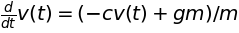

In [15]:
t, m, c, g = sym.symbols('t m c g')
v = sym.Function('v')(t)
dvdt = v.diff(t)
expr = sym.Eq(dvdt, ((m*g)-(c*v))/m)
expr

#### Determine what kind of ODE it is (wish this existed when I took DiffEQ)

In [16]:
sym.classify_ode(expr)

('separable',
 '1st_linear',
 'Bernoulli',
 'almost_linear',
 '1st_power_series',
 'lie_group',
 'nth_linear_constant_coeff_undetermined_coefficients',
 'nth_linear_constant_coeff_variation_of_parameters',
 'separable_Integral',
 '1st_linear_Integral',
 'Bernoulli_Integral',
 'almost_linear_Integral',
 'nth_linear_constant_coeff_variation_of_parameters_Integral')

#### Solve for the general expression

In [17]:
soln = sym.dsolve(expr,v)
soln

#### Find the exact solution for initial conditions ($v=0$ at $t = 0$)


In [18]:
ics = [soln.lhs.subs(t,0) - 0,soln.rhs.subs(t,0) - 0]
ics

In [19]:
constant = sym.solve(ics) 
constant

#### Substitute Coefficient to Find Exact Solution

In [20]:
C1 = sym.symbols('C1')

In [21]:
ext_soln = soln.subs(constant[0])
ext_soln

#### Make it pretty with simplify

In [22]:
sym.simplify(ext_soln)

#### Evaluating for specific values (Substitution)
If the falling object is on Earth ($9.81m/s$), has a mass of $68kg$, and has a drag coefficient of $12.5kg/s$. 

In [23]:
ext_soln_const = ext_soln.subs([(g, 9.81),(m, 68.),(c, 12.5)])

In [24]:
sym.simplify(ext_soln_const)

#### Plotting 

In [25]:
p1 = sym.plot(ext_soln_const.rhs,xlim = {0,12}, ylim = {0,100},xlabel = 'time (t)',ylabel = 'Velocity',show=False)
p1.show()

<Figure size 640x480 with 1 Axes>

In [36]:
times = [0,2,4,6,8,10,12,sym.oo] #sym.oo is infinity
for time in times:
    v=sym.simplify(ext_soln_const.subs(t,time))
    print(v)

Eq(v(0), 3.5527136788005e-14)
Eq(v(2), 16.4175591688156)
Eq(v(4), 27.7844450851434)
Eq(v(6), 35.6544392850263)
Eq(v(8), 41.1033202856899)
Eq(v(10), 44.8759157165525)
Eq(v(12), 47.4879155534424)
Eq(v(oo), 53.3664)


### Numerical Solution

We can approximate the Second law derivative using what is known as a *finite difference*, meaning we can compute the slope on ever more refined finite intervals. So an approximation of the derivative is as follows:

$$\frac{dv}{dt}\cong\frac{\Delta v}{\Delta t}=\frac{v(t_{i+1})-v(t_i)}{t_{i+1}-t_i}$$

where $\Delta v$ and $\Delta t$ are the differences in velocity and time computed over finite intervals. This is visualized below.

![finite difference](fig2.png)

Remember your calculus. 

$$\frac{dv}{dt}=\lim_{t \to 0} \frac{\Delta v}{\Delta t}$$

So to best approximate the solution, we would continue to shrink the difference, here called the time step ($\Delta t$) to improve our results. Lets substitute and test it out.

$$\frac{v(t_{i+1})-v(t_i)}{t_{i+1}-t_i}=g-\frac{c}{m}v(t_i)$$

If we rearrange this we get the following:

$$v(t_{i+1})=v(t_i)+\left [g-\frac{c}{m}v(t_i)\right](t_{i+1}-t_i)$$

Now we have an algebraic equation that we can use to solve numerically for the solution. Using the following algorithm:

$$New\space Value = old\space value+slope \times step\space size$$

This is called Euler's Method and we will come back to it later in this course.

Now lets create a function that will call the algebraic equation defined above for the differential. 

In [27]:
def diff(vti,ti,g,c,m,delt):
    ti_1 = ti+delt
    vti_1=vti+(g-(c/m)*vti)*(ti_1-ti)
    return vti_1

#### Testing the algebraic solution for values of $g=9.81m/s^2$, $c=12.5kg/s$, and $m=68.0$. Using a time step of 2 seconds

In [28]:
g = 9.81
c = 12.5
m = 68.
delt = 2
diff(0,0,g,c,m,delt)

In [29]:
v = (g*m+expr)

In [30]:
g = 9.81
c = 12.5
m = 68.
v = sym.simplify(ext_soln_const)
print(v)

Eq(v(t), 53.3664*exp(-0.183823529411765*t + 1.0*I*pi) + 53.3664)


#### Creating a loop to calculate at different time steps (0sec, 2sec, 4sec etc) and print the values

In [58]:

g = 9.81
c = 12.5
m = 68.0

delt = 2
tt = 0
vv_numerical = 0
v_analytical = 0

import math
           
while tt <= 12:
    print(tt,vv_numerical,v_analytical)
    vv_numerical = diff(vv_numerical,tt,g,c,m,delt)
    tt += 2
    a=math.exp(-c*tt/m)
    v_analytical = (g*m/c)*(1-a)

0 0 0
2 19.62 16.417559168815526
4 32.02676470588236 27.784445085143368
6 39.87221885813149 35.65443928502625
8 44.833314866171385 41.10332028568992
10 47.97047851831426 44.87591571655254
12 49.95427318069872 47.48791555344236


#### Comparison of the numerical solution with the results of the analytical solution and calculating the error

In [88]:
g = 9.81
c = 12.5
m = 68.0

delt = 2
tt = 0
vv_numerical = 0
v_analytical = 0
err=0
relative_err = -100
import math
           
while tt <= 12:
    print(tt,vv_numerical,v_analytical,err,relative_err)
    vv_numerical = diff(vv_numerical,tt,g,c,m,delt)
    tt += delt
    a=math.exp(-c*tt/m)
    v_analytical = (g*m/c)*(1-a)
    err=vv_numerical-v_analytical
    relative_err=err/v_analytical

0 0 0 0 -100
2 19.62 16.417559168815526 3.202440831184475 0.19506193327857035
4 32.02676470588236 27.784445085143368 4.242319620738989 0.15268685797894166
6 39.87221885813149 35.65443928502625 4.21777957310524 0.11829605675152421
8 44.833314866171385 41.10332028568992 3.729994580481467 0.09074679501694809
10 47.97047851831426 44.87591571655254 3.094562801761718 0.06895820959527038
12 49.95427318069872 47.48791555344236 2.4663576272563574 0.051936531610463015


In [90]:
import pandas as pd
df = pd.DataFrame({'Numerical Velocity':[0,19.62,32.03,39.87,44.83,47.97,49.95], 'Analytical Velocity':[0,16.42,27.78,35.65,41.10,44.88,47.49],'Absolute Error':[0,3.20,4.24,4.21,3.73,3.09,2.47],'Relative Error':[-100,0.195,0.153,0.118,0.091,0.069,0.052]})
df

,Numerical Velocity,Analytical Velocity,Absolute Error,Relative Error
0,0.00,0.00,0.00,-100.000
1,19.62,16.42,3.20,0.195
2,32.03,27.78,4.24,0.153
3,39.87,35.65,4.21,0.118
4,44.83,41.10,3.73,0.091
5,47.97,44.88,3.09,0.069
6,49.95,47.49,2.47,0.052


#### Plotting

0 0 0 0 -100
2 19.62 16.417559168815526 3.202440831184475 0.19506193327857035
4 32.02676470588236 27.784445085143368 4.242319620738989 0.15268685797894166
6 39.87221885813149 35.65443928502625 4.21777957310524 0.11829605675152421
8 44.833314866171385 41.10332028568992 3.729994580481467 0.09074679501694809
10 47.97047851831426 44.87591571655254 3.094562801761718 0.06895820959527038
12 49.95427318069872 47.48791555344236 2.4663576272563574 0.051936531610463015


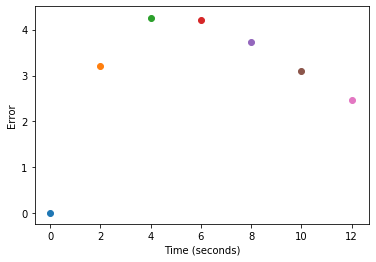

In [76]:
g = 9.81
c = 12.5
m = 68.0

delt = 2
tt = 0
vv_numerical = 0
v_analytical = 0
err=0
relative_err = -100
import math
import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
while tt <= 12:
    print(tt,vv_numerical,v_analytical,err,relative_err)
    p22 = plt.scatter(tt,err)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Error')
    vv_numerical = diff(vv_numerical,tt,g,c,m,delt)
    tt += delt
    a=math.exp(-c*tt/m)
    v_analytical = (g*m/c)*(1-a)
    err=vv_numerical-v_analytical
    relative_err=err/v_analytical
    
    

#### Create a table in Pandas with all the values

In [71]:
import pandas as pd
df = pd.DataFrame({'Numerical Velocity':np.round(vv_numerical,2), 'Analytical Velocity':np.round(v_analytical,2),'Absolute Error':np.round(err.2),'Relative Error':np.round(relative_err,2)})
df

SyntaxError: invalid syntax (<ipython-input-71-58e6ad46da67>, line 2)

### Approximation and Error
It can be seen that for the time step of 2 seconds, the numerical model underestimates the analytical value by upwards of 20% that becomes lower as the time increases. However, we can use more computational time to make a more accurate estimate.

0 0 0 0 -100
1 9.81 8.961145588688234 0.8488544113117662 0.09472610425873292
2 17.81669117647059 16.417559168815526 1.3991320076550657 0.08522168205811367
3 24.351564121972324 22.621911383345875 1.7296527386264486 0.0764591775343886
4 29.68517365837447 27.784445085143368 1.9007285732311026 0.06840980870434737
5 34.03834026529093 32.08009969994385 1.9582405653470758 0.061042221927711256
6 37.59129242240657 35.65443928502625 1.936853137380318 0.05432291675930901
7 40.49112837417007 38.62858516385649 1.862543210313575 0.048216707974494906
8 42.85790624656528 41.10332028568992 1.7545859608753602 0.042687207473266285
9 44.78961465712313 43.16250439189948 1.6271102652236493 0.03769730899880353
10 46.366229609857854 44.87591571655254 1.4903138933053128 0.033209659780950355
11 47.65302563745751 46.30161551609761 1.3514101213598977 0.02918710516461472
12 48.70327827763076 47.48791555344236 1.2153627241883953 0.025593094791045098


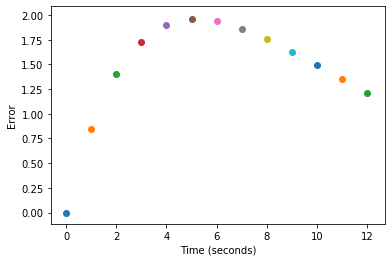

In [77]:
g = 9.81
c = 12.5
m = 68.0

delt = 1
tt = 0
vv_numerical = 0
v_analytical = 0
err=0
relative_err = -100
import math
import matplotlib.pyplot as plt           
while tt <= 12:
    print(tt,vv_numerical,v_analytical,err,relative_err)
    p22 = plt.scatter(tt,err)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Error')
    vv_numerical = diff(vv_numerical,tt,g,c,m,delt)
    tt += delt
    a=math.exp(-c*tt/m)
    v_analytical = (g*m/c)*(1-a)
    err=vv_numerical-v_analytical
    relative_err=err/v_analytical

0 0 0 0 -100
0.1 0.9810000000000001 0.9720384513459996 0.00896154865400045 0.009219335553641144
0.2 1.943966911764706 1.9263717782898506 0.017595133474855418 0.009133820207060765
0.30000000000000004 2.889232225886679 2.863322469545505 0.025909756341174095 0.009048843298913081
0.4 3.817121339381409 3.783207139879462 0.03391419950194674 0.008964404603821743
0.5 4.727953667701604 4.686336637101342 0.04161703060026145 0.008880503861114636
0.6 5.622042754692383 5.573016147105711 0.0490266075866721 0.008797140774862742
0.7 6.4996963805252435 6.443545297000635 0.0561510835246084 0.008714315013932751
0.7999999999999999 7.361216667647941 7.298218256357776 0.06299841129016492 0.008632026212053117
0.8999999999999999 8.206900184786765 8.137323836618314 0.06957634816845015 0.00855027396788039
0.9999999999999999 9.037038049037008 8.961145588688229 0.07589246034877917 0.008469057845079451
1.0999999999999999 9.851916026076768 9.769961898755925 0.08195412732084328 0.008388377372411151
1.2 10.6518146285

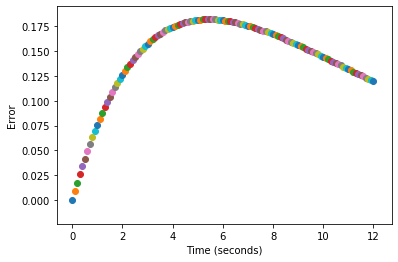

In [81]:
g = 9.81
c = 12.5
m = 68.0

delt = 0.1
tt = 0
vv_numerical = 0
v_analytical = 0
err=0
relative_err = -100
import math
import matplotlib.pyplot as plt           
while tt <= 12:
    print(tt,vv_numerical,v_analytical,err,relative_err)
    p22 = plt.scatter(tt,err)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Error')
    vv_numerical = diff(vv_numerical,tt,g,c,m,delt)
    tt += delt
    a=math.exp(-c*tt/m)
    v_analytical = (g*m/c)*(1-a)
    err=vv_numerical-v_analytical
    relative_err=err/v_analytical

0 0 0 0 -100
0.01 0.0981 0.09800988978187547 9.011021812453668e-05 0.0009193992394551224
0.02 0.19601966911764707 0.19583977981681097 0.00017988930083609467 0.0009185534267060736
0.03 0.2937593388435337 0.2934900006827593 0.00026933816077440165 0.0009177081336598448
0.04 0.3913193400588949 0.39096088235056464 0.000358457708330262 0.0009168633602807406
0.05 0.48870000303672784 0.4882527541850349 0.0004472488516929496 0.0009160191066192206
0.060000000000000005 0.5859016574429103 0.5853659449461149 0.0005357124967954041 0.0009151753726375702
0.07 0.6829246323373168 0.6823007827899472 0.0006238495473696037 0.0009143321583461553
0.08 0.779769256174932 0.7790575952700148 0.0007116609049171441 0.0009134894637289152
0.09 0.8764358568069633 0.8756367093382145 0.0007991474687488731 0.0009126472887972569
0.09999999999999999 0.9729247614819505 0.9720384513459996 0.0008863101359508629 0.0009118056335359706
0.10999999999999999 1.0692362968468734 1.068263147045453 0.00097314980142027 0.00091096449794

1.5600000000000012 13.315436341446501 13.304865739716977 0.010570601729524398 0.0007944914241388849
1.5700000000000012 13.389059436407077 13.37844062124062 0.010618815166457907 0.0007937259256956059
1.5800000000000012 13.462547194796034 13.451880379052916 0.010666815743118008 0.0007929609424514529
1.5900000000000012 13.535899865393835 13.52518526131489 0.0107146040789452 0.000792196474350071
1.6000000000000012 13.609117696523626 13.598355515731802 0.010762180791823894 0.0007914325213348949
1.6100000000000012 13.682200936052075 13.67139138955398 0.010809546498094846 0.0007906690833497892
1.6200000000000012 13.755149831390215 13.744293129577674 0.010856701812540948 0.0007899061603377303
1.6300000000000012 13.827964629494277 13.817060982145875 0.010903647348401435 0.0007891437522415879
1.6400000000000012 13.90064557686653 13.889695193149164 0.010950383717366563 0.0007883818590034746
1.6500000000000012 13.973192919556114 13.962196008026519 0.010996911529595366 0.0007876204805657731
1.66000

2.389999999999993 18.987644528980404 18.973742420151527 0.013902108828876436 0.0007327025170380389
2.399999999999993 19.05084077065507 19.036906144493187 0.013934626161884012 0.0007319795588693852
2.4099999999999926 19.113920842767836 19.09995386570065 0.013966977067187969 0.0007312571101163555
2.4199999999999924 19.17688495886569 19.162885796819086 0.01399916204660201 0.0007305351706957299
2.429999999999992 19.239733332103068 19.22570215050242 0.014031181600646647 0.0007298137405233844
2.439999999999992 19.302466175242582 19.288403139014026 0.014063036228556314 0.0007290928195145128
2.4499999999999917 19.365083700655738 19.35098897422742 0.014094726428318438 0.0007283724075854973
2.4599999999999915 19.42758612032365 19.413459867627036 0.01412625269661305 0.0007276525046506172
2.4699999999999913 19.489973645837757 19.475816030308877 0.014157615528880285 0.0007269331106253909
2.479999999999991 19.552246488400556 19.538057672981285 0.01418881541927064 0.0007262142254238513
2.489999999999

3.9999999999999587 27.801749289389218 27.78444508514317 0.017304204246048727 0.0006228018660448824
4.009999999999959 27.848743132607254 27.83142754192515 0.01731559068210231 0.0006221596307274636
4.019999999999959 27.895650590084077 27.878323713227676 0.01732687685640144 0.000621517887324775
4.0299999999999585 27.94247182061701 27.92513375751807 0.017338063098939926 0.000620876635703567
4.039999999999958 27.989206982711462 27.971857832972606 0.017349149738855374 0.0006202358757309491
4.049999999999958 28.035856234581477 28.018496097477076 0.017360137104400764 0.0006195956072732953
4.059999999999958 28.08241973415026 28.06504870862731 0.017371025522951555 0.0006189558301964262
4.069999999999958 28.12889763905072 28.111515823729693 0.017381815321027005 0.0006183165443662964
4.079999999999957 28.175290106625994 28.15789759980172 0.017392506824272402 0.000617677749648286
4.089999999999957 28.22159729392999 28.20419419357251 0.017403100357480383 0.0006170394459078856
4.099999999999957 28.26

4.849999999999941 31.502939407832482 31.484994400187986 0.017945007644495803 0.000569954290491748
4.859999999999941 31.543129592744553 31.52518062506188 0.017948967682674066 0.0005693533653667634
4.869999999999941 31.583245898640243 31.5652930460541 0.017952852586141432 0.0005687529198587837
4.87999999999994 31.623288461326567 31.60533179870894 0.017956662617628183 0.0005681529538114737
4.88999999999994 31.663257416360892 31.64529701832173 0.017960398039161163 0.0005675534670685063
4.89999999999994 31.703152899051403 31.68518883993936 0.017964059112042463 0.0005669544594728331
4.90999999999994 31.74297504445756 31.725007398360674 0.01796764609688495 0.0005663559308677542
4.9199999999999395 31.78272398739054 31.764752828136956 0.017971159253583835 0.0005657578810959652
4.929999999999939 31.822399862413718 31.80442526357238 0.017974598841338008 0.0005651603100001763
4.939999999999939 31.862002803843104 31.84402483872448 0.01797796511862515 0.0005645632174222755
4.949999999999939 31.90153

6.28999999999991 36.5917754598054 36.57391719070423 0.01785826910116839 0.00048827881924847025
6.29999999999991 36.622611166680755 36.60475737084198 0.017853795838775 0.0004877452309790936
6.30999999999991 36.653390190271416 36.63554091154638 0.01784927872503772 0.0004872120973492215
6.31999999999991 36.68411263477459 36.666267916838386 0.017844717936206678 0.00048667941816930274
6.3299999999999095 36.71477860419596 36.69693849054793 0.017840113648034617 0.00048614719324964164
6.339999999999909 36.745388202350014 36.727552736314266 0.017835466035748482 0.00048561542239959035
6.349999999999909 36.7759415328604 36.758110757586294 0.01783077527410626 0.00048508410542906554
6.359999999999909 36.80643869916029 36.78861265762291 0.01782604153737566 0.00048455324214793276
6.369999999999909 36.83687980449272 36.81905853949341 0.017821264999305697 0.0004840228323651998
6.379999999999908 36.867264951910926 36.84944850607777 0.017816445833155115 0.0004834928758897587
6.389999999999908 36.89759424

7.679999999999881 40.37721019141512 40.36032405623777 0.016886135177344386 0.00041838452916818437
7.6899999999998805 40.40108737856325 40.38421032306002 0.0168770555032296 0.0004179122327320224
7.69999999999988 40.42492067382324 40.40805272163598 0.016867952187254787 0.0004174403627775672
7.70999999999988 40.44871015787871 40.43185133253175 0.01685882534695793 0.00041696891909060813
7.71999999999988 40.47245591126496 40.45560623616544 0.016849675099521733 0.000416497901456706
7.72999999999988 40.49615801436925 40.47931751280748 0.016840501561773635 0.0004160273096611714
7.739999999999879 40.51981654743107 40.50298524258089 0.016831304850178697 0.00041555714348886813
7.749999999999879 40.54343159054241 40.52660950546152 0.016822085080889337 0.0004150874027254199
7.759999999999879 40.56700322364803 40.55019038127837 0.016812842369660075 0.0004146180871550828
7.769999999999879 40.59053152654573 40.57372794971379 0.016803576831939893 0.00041414919656300464
7.779999999999879 40.614016578886

8.939999999999854 43.06492935438794 43.04933849620006 0.015590858187884749 0.0003621625495885598
8.949999999999854 43.083865881310025 43.068286262226245 0.015579619083780472 0.0003617422571430439
8.959999999999853 43.10276759843997 43.08719922979387 0.015568368646100339 0.0003613223631239217
8.969999999999853 43.121634569766364 43.1060774628119 0.015557106954460664 0.0003609028673017617
8.979999999999853 43.14046685916018 43.12492102507198 0.01554583408820065 0.00036048376944650194
8.989999999999853 43.159264530374955 43.14372998024857 0.015534550126382385 0.00036006506932743606
8.999999999999853 43.17802764704706 43.162504391899205 0.015523255147854798 0.0003596467667146817
9.009999999999852 43.19675627269587 43.181244323464675 0.015511949231196809 0.0003592288613778464
9.019999999999852 43.215450470724 43.199949838269276 0.015500632454724439 0.0003588113530861785
9.029999999999852 43.23411030441752 43.21862099952101 0.015489304896512124 0.0003583942416090461
9.039999999999852 43.2527

10.259999999999826 45.28620252293008 45.272166272445915 0.014036250484167567 0.0003100415031986326
10.269999999999825 45.301055827115874 45.28703171128957 0.014024115826302364 0.00030967178232629237
10.279999999999825 45.31588182743368 45.30186984905948 0.01401197837419943 0.00030930242881553675
10.289999999999825 45.33068057407443 45.31668073589532 0.013999838179110213 0.000308933442427105
10.299999999999825 45.345452117136794 45.331464421844714 0.013987695292080105 0.00030856482292108777
10.309999999999825 45.360196506627354 45.34622095686337 0.013975549763983963 0.00030819657005770173
10.319999999999824 45.37491379246076 45.36095039081523 0.013963401645526119 0.0003078286835972787
10.329999999999824 45.38960402445991 45.37565277347268 0.013951250987233266 0.00030746116330009884
10.339999999999824 45.40426725235613 45.39032815451669 0.013939097839440251 0.00030709400892606686
10.349999999999824 45.4189035257893 45.40497658353697 0.013926942252325603 0.0003067272202354854
10.359999999

11.319999999999803 46.71794791278523 46.70520444300558 0.01274346977965024 0.00027284903110104386
11.329999999999803 46.7301693320632 46.717438040219484 0.012731291843714132 0.0002725169096976945
11.339999999999803 46.74236828549691 46.72964916985989 0.012719115637018774 0.00027218513006133294
11.349999999999802 46.75454481438386 46.74183787318955 0.012706941194309707 0.0002718536919490328
11.359999999999802 46.76669895994566 46.754004191395424 0.012694768550232993 0.0002715225951185873
11.369999999999802 46.77883076332811 46.766148165588845 0.012682597739264168 0.00027119183932698123
11.379999999999802 46.7909402656014 46.77826983680562 0.012670428795779287 0.00027086142433190344
11.389999999999802 46.80302750776022 46.79036924600623 0.012658261753990985 0.0002705313498903714
11.399999999999801 46.815092530723895 46.802446434075904 0.0126460966479911 0.0002702016157596355
11.409999999999801 46.82713537533653 46.814501441824774 0.012633933511757789 0.00026987222169732315
11.41999999999

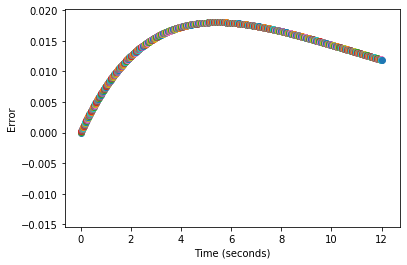

In [83]:
g = 9.81
c = 12.5
m = 68.0

delt = 0.01
tt = 0
vv_numerical = 0
v_analytical = 0
err=0
relative_err = -100
import math
import matplotlib.pyplot as plt           
while tt <= 12:
    print(tt,vv_numerical,v_analytical,err,relative_err)
    p22 = plt.scatter(tt,err)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Error')
    vv_numerical = diff(vv_numerical,tt,g,c,m,delt)
    tt += delt
    a=math.exp(-c*tt/m)
    v_analytical = (g*m/c)*(1-a)
    err=vv_numerical-v_analytical
    relative_err=err/v_analytical

0 0 0 0 -100
0.001 0.009810000000000001 0.00980909840083561 9.015991643910454e-07 9.191458047910302e-05
0.002 0.019618196691176475 0.019616393824298337 1.8028668781373824e-06 9.190613189587458e-05
0.003 0.029424590405020008 0.029421886601795254 2.7038032247538035e-06 9.189768356284888e-05
0.004 0.03922918147296026 0.03922557706466235 3.6044082979136416e-06 9.188923573952443e-05
0.005 0.04903197022636597 0.049027465544170416 4.504682195552445e-06 9.188078856521826e-05
0.006 0.05883295699654495 0.0588275523715488 5.404624996152574e-06 9.187234175607912e-05
0.007 0.06863214211474411 0.06862583787794387 6.3042368002447224e-06 9.186389551202674e-05
0.008 0.0784295259121495 0.0784223223944487 7.2035177007961915e-06 9.18554498368963e-05
0.009000000000000001 0.08822510871988624 0.08821700625210302 8.102467783224765e-06 9.184700464749231e-05
0.010000000000000002 0.09801889086901863 0.09800988978187547 9.001087143162279e-06 9.183855999832794e-05
0.011000000000000003 0.10781087269055008 0.1078009

0.1510000000000001 1.4610727213983892 1.4609402827113969 0.00013243868699230887 9.065304623301405e-05
0.1520000000000001 1.4706141418540144 1.470480850595068 0.00013329125894645522 9.064467510237585e-05
0.1530000000000001 1.480153808372056 1.480019664859069 0.0001341435129869062 9.063630448429187e-05
0.1540000000000001 1.4896917212749288 1.4895567258257185 0.0001349954492102512 9.062793438458548e-05
0.1550000000000001 1.4992278808849886 1.4990920338172817 0.0001358470677068624 9.061956480479853e-05
0.1560000000000001 1.508762287524532 1.50862558915597 0.0001366983685620049 9.061119574306271e-05
0.1570000000000001 1.5182949415157958 1.5181573921639355 0.00013754935186027772 9.060282719713208e-05
0.1580000000000001 1.5278258431809584 1.527687443163266 0.00013840001769227506 9.059445916875554e-05
0.1590000000000001 1.5373549928421384 1.5372157424759898 0.0001392503661485911 9.05860916596527e-05
0.16000000000000011 1.5468823908213953 1.5467422904240808 0.00014010039731449098 9.057772466806

0.3040000000000002 2.900702672945056 2.9004434362900025 0.00025923665505356297 8.937828326869776e-05
0.3050000000000002 2.909979455541941 2.9097194139430864 0.00026004159885451017 8.936999134982454e-05
0.3060000000000002 2.9192545328479076 2.918993686609937 0.00026084623797073547 8.936169994724356e-05
0.3070000000000002 2.9285279051764284 2.928266254603931 0.00026165057249727397 8.93534090644582e-05
0.3080000000000002 2.937799572840918 2.937537118238412 0.0002624546025060681 8.93451186970728e-05
0.3090000000000002 2.947069536154734 2.9468062778266435 0.00026325832809037664 8.933682884798841e-05
0.3100000000000002 2.956337795431176 2.9560737336818446 0.00026406174933146787 8.932853951602015e-05
0.3110000000000002 2.9656043509834866 2.965339486117167 0.0002648648663194919 8.932025070300045e-05
0.3120000000000002 2.97486920312485 2.9746035354457163 0.00026566767913349665 8.93119624070133e-05
0.3130000000000002 2.984132352168393 2.983865881980533 0.0002664701878600795 8.93036746287037e-05


0.3870000000000003 3.6649012200827062 3.6645762021663617 0.0003250179163445388 8.869181548261986e-05
0.3880000000000003 3.674037525005485 3.673711727147138 0.00032579785834707664 8.868356652471439e-05
0.3890000000000003 3.683172150460447 3.6828455729578033 0.0003265775026437545 8.867531808602834e-05
0.3900000000000003 3.6923050967563182 3.6919777399070073 0.00032735684931095577 8.866707016472997e-05
0.3910000000000003 3.7014363642017676 3.7011082283033336 0.00032813589843394553 8.86588227614111e-05
0.3920000000000003 3.710565953105407 3.710237038455321 0.0003289146500859985 8.865057587343131e-05
0.3930000000000003 3.719693863775792 3.7193641706714278 0.00032969310436437027 8.864232950462965e-05
0.3940000000000003 3.7288200965214218 3.7284896252600737 0.00033047126134810867 8.863408365392925e-05
0.3950000000000003 3.7379446516507375 3.737613402529618 0.0003312491211193702 8.862583832110103e-05
0.3960000000000003 3.747067529472125 3.7467355027883724 0.0003320266837527619 8.86175935039084

0.5290000000000004 4.945586680607374 4.9451538528300665 0.00043282777730713207 8.752564433550003e-05
0.5300000000000004 4.954487565408733 4.954053999142144 0.00043356626658841435 8.75174688575239e-05
0.5310000000000004 4.963386814018032 4.962952509548272 0.0004343044697607823 8.750929389818254e-05
0.5320000000000004 4.972284426736044 4.971849384349148 0.00043504238689617836 8.750111945579957e-05
0.5330000000000004 4.981180403863482 4.980744623845401 0.000435780018081644 8.749294553174633e-05
0.5340000000000004 4.9900747457010075 4.989638228337622 0.000436517363385569 8.748477212364989e-05
0.5350000000000004 4.998967452549224 4.998530198126326 0.00043725442289854755 8.747659923360076e-05
0.5360000000000004 5.007858524708682 5.007420533511986 0.0004379911966960748 8.74684268606629e-05
0.5370000000000004 5.016747962479876 5.016309234795018 0.0004387276848580868 8.746025500479628e-05
0.5380000000000004 5.025635766163243 5.025196302275774 0.0004394638874689605 8.745208366684884e-05
0.539000

0.6830000000000005 6.297225253553983 6.296682021703736 0.0005432318502469613 8.627271448272615e-05
0.6840000000000005 6.305877675382374 6.305333748171108 0.0005439272112655047 8.626461865294178e-05
0.6850000000000005 6.314528506692046 6.313983884393761 0.0005446222982845583 8.625652333872728e-05
0.6860000000000005 6.323177747775374 6.3226324306639805 0.0005453171113938282 8.624842854205917e-05
0.6870000000000005 6.33182539892468 6.331279387274008 0.0005460116506723622 8.624033426322269e-05
0.6880000000000005 6.340471460432231 6.339924754516047 0.0005467059161841092 8.623224050012272e-05
0.6890000000000005 6.34911593259024 6.348568532682217 0.0005473999080232161 8.62241472554356e-05
0.6900000000000005 6.357758815690866 6.357210722064614 0.0005480936262527436 8.62160545269358e-05
0.6910000000000005 6.366400110026217 6.365851322955262 0.0005487870709552922 8.62079623154826e-05
0.6920000000000005 6.375039815888345 6.374490335646137 0.0005494802422072453 8.619987062095819e-05
0.693000000000

0.7930000000000006 7.239519286204892 7.238901190657174 0.0006180955477184114 8.538527207915907e-05
0.7940000000000006 7.247998492218458 7.247379730989766 0.0006187612286918664 8.537723310482076e-05
0.7950000000000006 7.256476139554447 7.255856712910386 0.0006194266440608942 8.536919464778638e-05
0.7960000000000006 7.264952228499382 7.264332136705489 0.0006200917938929962 8.536115670699762e-05
0.7970000000000006 7.273426759339731 7.272806002661465 0.0006207566782663321 8.535311928286933e-05
0.7980000000000006 7.281899732361912 7.281278311064656 0.0006214212972555089 8.534508237532892e-05
0.7990000000000006 7.290371147852286 7.289749062201351 0.0006220856509351336 8.533704598430673e-05
0.8000000000000006 7.298841006097167 7.2982182563577815 0.0006227497393851422 8.532901011046621e-05
0.8010000000000006 7.307309307382811 7.306685893820135 0.0006234135626757009 8.532097475313302e-05
0.8020000000000006 7.3157760519954245 7.315151974874536 0.0006240771208885221 8.531293991321701e-05
0.803000

0.9340000000000007 8.419833388833634 8.419124019749468 0.0007093690841664113 8.425687547806433e-05
0.9350000000000007 8.42809562534304 8.427385627295406 0.0007099980476343859 8.424890933372951e-05
0.9360000000000007 8.43635634305897 8.435645716303066 0.0007106267559038315 8.424094370516839e-05
0.9370000000000007 8.444615542260614 8.44390428705156 0.0007112552090546842 8.423297859325217e-05
0.9380000000000007 8.45287322322711 8.452161339819957 0.0007118834071526692 8.422501399716931e-05
0.9390000000000007 8.461129386237547 8.460416874887272 0.0007125113502741698 8.421704991737341e-05
0.9400000000000007 8.469384031570959 8.468670892532465 0.000713139038493793 8.420908635410868e-05
0.9410000000000007 8.477637159506331 8.47692339303445 0.0007137664718808168 8.420112330699176e-05
0.9420000000000007 8.485888770322598 8.485174376672086 0.0007143936505116244 8.419316077648036e-05
0.9430000000000007 8.494138864298641 8.49342384372419 0.0007150205744519411 8.41851987617775e-05
0.9440000000000007

1.0819999999999916 9.626269779148057 9.625470061400762 0.0007997177472951478 8.308350056607704e-05
1.0829999999999915 9.634310244262183 9.633509934540262 0.000800309721920911 8.307561079596312e-05
1.0839999999999914 9.642349231349634 9.641548329897727 0.0008009014519068103 8.306772154253215e-05
1.0849999999999913 9.650386740682105 9.649585247744803 0.0008014929373025836 8.305983280368449e-05
1.0859999999999912 9.658422772531244 9.657620688353044 0.0008020841782006016 8.305194458174403e-05
1.086999999999991 9.666457327168645 9.665654651993993 0.0008026751746523786 8.304405687480147e-05
1.087999999999991 9.674490404865857 9.673687138939115 0.0008032659267414033 8.303616968426116e-05
1.0889999999999909 9.682522005894374 9.681718149459845 0.0008038564345280719 8.302828300913924e-05
1.0899999999999908 9.690552130525642 9.689747683827557 0.000804446698085215 8.302039684974023e-05
1.0909999999999906 9.69858077903106 9.697775742313581 0.0008050367174785578 8.301251120563668e-05
1.0919999999999

1.2169999999999768 10.698472109313748 10.697594660022368 0.0008774492913801168 8.202304529813641e-05
1.2179999999999767 10.7063154784113 10.7054374695472 0.0008780088641007211 8.201522512258975e-05
1.2189999999999765 10.714157405713062 10.7132788375116 0.0008785682014611496 8.200740546254807e-05
1.2199999999999764 10.721997891484069 10.721118764180545 0.0008791273035235747 8.199958631749843e-05
1.2209999999999763 10.72983693598931 10.728957249818949 0.0008796861703608272 8.199176768792437e-05
1.2219999999999762 10.737674539493723 10.73679429469168 0.0008802448020421849 8.19839495739787e-05
1.222999999999976 10.745510702262198 10.744629899063572 0.0008808031986262677 8.19761319748233e-05
1.223999999999976 10.753345424559576 10.752464063199392 0.0008813613601841297 8.196831489078058e-05
1.2249999999999759 10.761178706650648 10.760296787363869 0.0008819192867797199 8.196049832151317e-05
1.2259999999999758 10.76901054880016 10.768128071821666 0.0008824769784947506 8.1952682268336e-05
1.226

1.3489999999999622 11.721429776262621 11.720480473189465 0.0009493030731562158 8.099523524890821e-05
1.3499999999999621 11.729085101671396 11.72813526951509 0.0009498321563068401 8.098748304649388e-05
1.350999999999962 11.736739019851235 11.735788658838358 0.0009503610128778206 8.097973135892259e-05
1.351999999999962 11.74439153106082 11.743440641417886 0.0009508896429348823 8.09719801862151e-05
1.3529999999999618 11.752042635558787 11.751091217512252 0.0009514180465348687 8.096422952763763e-05
1.3539999999999617 11.75969233360372 11.75874038737997 0.0009519462237506104 8.095647938381935e-05
1.3549999999999616 11.76734062545416 11.766388151279509 0.0009524741746513854 8.094872975508724e-05
1.3559999999999615 11.774987511368598 11.774034509469304 0.000953001899294037 8.09409806407126e-05
1.3569999999999613 11.782632991605478 11.781679462207729 0.0009535293977496195 8.093323204117632e-05
1.3579999999999612 11.790277066423197 11.789323009753122 0.0009540566700749764 8.092548395575389e-05


1.4759999999999482 12.682482613290128 12.681467907897392 0.0010147053927358485 8.001482163621926e-05
1.4769999999999481 12.689961274574449 12.68894606835645 0.0010152062179979993 8.000713475563656e-05
1.477999999999948 12.697438561104857 12.696422854280012 0.0010157068248446421 7.999944838811378e-05
1.478999999999948 12.704914473134064 12.703898265920703 0.0010162072133610422 7.999176253537115e-05
1.4799999999999478 12.712389010914737 12.711372303531142 0.0010167073835951612 7.998407719619117e-05
1.4809999999999477 12.719862174699495 12.718844967363879 0.001017207335616277 7.997639237103654e-05
1.4819999999999476 12.72733396474091 12.726316257671417 0.001017707069491891 7.996870806023053e-05
1.4829999999999475 12.734804381291507 12.733786174706232 0.0010182065852752942 7.996102426298077e-05
1.4839999999999474 12.74227342460377 12.74125471872073 0.001018705883039317 7.995334098003174e-05
1.4849999999999473 12.749741094930128 12.748721889967282 0.001019204962846132 7.994565821129129e-05


1.595999999999935 13.570176816162205 13.569103553471763 0.001073262690441723 7.909606454194391e-05
1.596999999999935 13.577492298365115 13.57641856060979 0.0010737377553251548 7.908843930611163e-05
1.5979999999999348 13.584806435810268 13.583732223200979 0.0010742126092893045 7.908081458309023e-05
1.5989999999999347 13.592119228744862 13.591044541492456 0.0010746872524052264 7.907319037357913e-05
1.5999999999999346 13.599430677416047 13.598355515731315 0.0010751616847315404 7.906556667736294e-05
1.6009999999999345 13.606740782070933 13.605665146164604 0.0010756359063286425 7.905794349435838e-05
1.6019999999999344 13.61404954295658 13.612973433039313 0.001076109917267587 7.905032082526648e-05
1.6029999999999343 13.621356960320007 13.620280376602413 0.0010765837175945592 7.904269866896188e-05
1.6039999999999341 13.628663034408182 13.6275859771008 0.0010770573073823897 7.903507702627814e-05
1.604999999999934 13.635967765468033 13.634890234781343 0.0010775306866896983 7.902745589700584e-05

1.6999999999999236 14.323829250302781 14.322707699381386 0.001121550921395098 7.83057886075228e-05
1.7009999999999235 14.331006193455298 14.329884189077317 0.0011220043779811562 7.829821673202236e-05
1.7019999999999234 14.338181817316794 14.337059359686819 0.0011224576299753153 7.829064536982111e-05
1.7029999999999232 14.345356122129786 14.344233211452359 0.0011229106774273134 7.828307452020423e-05
1.7039999999999231 14.352529108136746 14.351405744616342 0.0011233635204046521 7.827550418369717e-05
1.704999999999923 14.359700775580103 14.358576959421143 0.0011238161589606221 7.826793435983562e-05
1.705999999999923 14.36687112470224 14.365746856109089 0.0011242685931502905 7.826036504828087e-05
1.7069999999999228 14.374040155745492 14.372915434922445 0.0011247208230464878 7.825279624993192e-05
1.7079999999999227 14.381207868952156 14.380082696103452 0.0011251728487042811 7.824522796445166e-05
1.7089999999999226 14.388374264564481 14.387248639894299 0.0011256246701822903 7.823766019175158

1.8129999999999111 15.12653184896147 15.12536033822242 0.0011715107390504187 7.745341022322371e-05
1.813999999999911 15.133561236489234 15.132389295037807 0.001171941451426406 7.744589625451331e-05
1.814999999999911 15.140589331850173 15.139416959884295 0.0011723719658771614 7.743838279794108e-05
1.8159999999999108 15.147616135281817 15.14644333299935 0.001172802282466634 7.743086985387953e-05
1.8169999999999107 15.154641647021654 15.15346841462041 0.0011732324012445616 7.742335742176362e-05
1.8179999999999106 15.161665867307127 15.16049220498486 0.0011736623222660114 7.741584550138183e-05
1.8189999999999105 15.168688796375635 15.167514704330037 0.001174092045598485 7.740833409334385e-05
1.8199999999999104 15.175710434464536 15.17453591289324 0.0011745215712952728 7.740082319732266e-05
1.8209999999999102 15.182730781811141 15.181555830911726 0.0011749508994149949 7.73933128133438e-05
1.8219999999999101 15.18974983865272 15.188574458622698 0.0011753800300216 7.738580294178468e-05
1.8229

1.9059999999999009 15.774767695700287 15.773556967925781 0.0012107277745059264 7.675680107967029e-05
1.9069999999999008 15.781677922226812 15.78046678189991 0.0012111403269017273 7.674933470858398e-05
1.9079999999999007 15.788586878491108 15.787375325804378 0.0012115526867297888 7.674186884944153e-05
1.9089999999999006 15.79549456472668 15.794282599872643 0.001211964854036296 7.673440350156003e-05
1.9099999999999004 15.802400981166986 15.801188604338101 0.0012123768288851977 7.672693866538297e-05
1.9109999999999003 15.809306128045447 15.808093339434116 0.0012127886113315611 7.671947434079204e-05
1.9119999999999002 15.816210005595439 15.814996805394015 0.0012132002014233478 7.671201052722073e-05
1.9129999999999001 15.823112614050292 15.82189900245106 0.001213611599231612 7.670454722556405e-05
1.9139999999999 15.830013953643297 15.828799930838494 0.0012140228048025392 7.669708443514512e-05
1.9149999999999 15.8369140246077 15.835699590789503 0.0012144338181965253 7.668962215618658e-05
1.9

2.0129999999998893 16.507004403320074 16.5057506133188 0.0012537900012752345 7.596079879357489e-05
2.013999999999889 16.51378002751064 16.512525845242866 0.0012541822677754055 7.595338711531682e-05
2.014999999999889 16.520554406182054 16.519299831834356 0.0012545743476977123 7.594597594748059e-05
2.015999999999889 16.52732753956327 16.52607257332216 0.0012549662411096563 7.59385652907959e-05
2.016999999999889 16.534099427883202 16.532844069935145 0.0012553579480574228 7.593115514470266e-05
2.0179999999998888 16.540870071370723 16.53961432190212 0.0012557494686014081 7.592374550950181e-05
2.0189999999998887 16.547639470254662 16.546383329451867 0.0012561408027949028 7.591633638506518e-05
2.0199999999998886 16.554407624763805 16.55315109281312 0.0012565319506840922 7.590892777083636e-05
2.0209999999998884 16.5611745351269 16.55991761221456 0.0012569229123400305 7.590151966776253e-05
2.0219999999998883 16.567940201572647 16.566682887884838 0.001257313687808903 7.589411207528893e-05
2.0229

2.1219999999998773 17.238264146708506 17.236968686282847 0.0012954604256592006 7.515593079252537e-05
2.122999999999877 17.244905348152123 17.243609515473544 0.0012958326785792451 7.514857474686088e-05
2.123999999999877 17.251545328786655 17.25024912403577 0.0012962047508864316 7.514121921174777e-05
2.124999999999877 17.258184088836508 17.25688751219389 0.0012965766426162872 7.513386418611775e-05
2.125999999999877 17.26482162852606 17.263524680172228 0.0012969483538327609 7.512650967055135e-05
2.1269999999998768 17.27145794807964 17.270160628195054 0.0012973198845855904 7.511915566480614e-05
2.1279999999998767 17.278093047721537 17.276795356486602 0.0012976912349351721 7.511180216925773e-05
2.1289999999998765 17.284726927676 17.283428865271066 0.0012980624049347966 7.510444918387081e-05
2.1299999999998764 17.291359588167236 17.29006115477261 0.0012984333946270965 7.509709670799444e-05
2.1309999999998763 17.29799102941941 17.29669222521533 0.0012988042040795733 7.508974474241731e-05
2.13

2.2219999999998663 17.896377412541913 17.895045612254872 0.0013318002870406076 7.442284953599476e-05
2.222999999999866 17.902897637282255 17.901565482540295 0.0013321547419593571 7.44155444538429e-05
2.223999999999866 17.90941666345187 17.90808415443031 0.0013325090215623447 7.440823988046166e-05
2.224999999999866 17.915934491271088 17.914601628145174 0.0013328631259135193 7.440093581648459e-05
2.225999999999866 17.92245112096019 17.921117903905127 0.0013332170550626188 7.439363226175205e-05
2.2269999999998658 17.928966552739425 17.927632981930365 0.0013335708090593812 7.438632921610539e-05
2.2279999999998656 17.935480786828993 17.934146862441025 0.0013339243879677554 7.437902668017932e-05
2.2289999999998655 17.94199382344906 17.940659545657237 0.0013342777918232684 7.437172465302409e-05
2.2299999999998654 17.94850566281975 17.947171031799062 0.0013346310206863166 7.436442313507782e-05
2.2309999999998653 17.95501630516114 17.95368132108653 0.0013349840746101904 7.435712212638288e-05
2.

2.3109999999998565 18.47200873394086 18.470646067742944 0.0013626661979166954 7.377469055056226e-05
2.3119999999998564 18.478423144100063 18.4770601388456 0.0013630052544613136 7.37674307611184e-05
2.3129999999998563 18.48483637513975 18.48347303099943 0.0013633441403193558 7.376017148037235e-05
2.313999999999856 18.491248427276673 18.489884744421136 0.0013636828555370073 7.375291270803972e-05
2.314999999999856 18.49765930072754 18.496295279327374 0.0013640214001675588 7.374565444422133e-05
2.315999999999856 18.504068995709023 18.502704635934755 0.0013643597742678537 7.373839668921065e-05
2.316999999999856 18.510477512437753 18.509112814459872 0.0013646979778805246 7.37311394425335e-05
2.3179999999998557 18.516884851130317 18.51551981511926 0.0013650360110588622 7.372388270429285e-05
2.3189999999998556 18.52329101200327 18.521925638129414 0.0013653738738561572 7.371662647459212e-05
2.3199999999998555 18.529695995273123 18.528330283706794 0.001365711566329253 7.370937075372706e-05
2.320

2.4009999999998466 19.044608636905426 19.043216133235735 0.0013925036696917914 7.312334533983907e-05
2.4019999999998465 19.050917789729525 19.049524962161406 0.0013928275681180935 7.311613128855995e-05
2.4029999999998464 19.057225782782883 19.055832631482463 0.001393151300419504 7.310891774510316e-05
2.4039999999998463 19.063532616278692 19.06213914141205 0.001393474866642208 7.310170470925357e-05
2.404999999999846 19.069838290430113 19.068444492163266 0.001393798266846602 7.309449218154235e-05
2.405999999999846 19.076142805450253 19.074748683949174 0.001394121501078871 7.308728016175553e-05
2.406999999999846 19.08244616155219 19.081051716982813 0.001394444569378095 7.308006864930771e-05
2.407999999999846 19.088748358948965 19.087353591477154 0.0013947674718117753 7.307285764510403e-05
2.4089999999998457 19.09504939785357 19.093654307645156 0.0013950902084118866 7.30656471481883e-05
2.4099999999998456 19.101349278478963 19.099953865699717 0.0013954127792459303 7.305843715946641e-05
2.4

2.5009999999998356 19.669817374354327 19.668393295103684 0.001424079250643473 7.240445262999637e-05
2.5019999999998355 19.676011599101688 19.67458721231902 0.0014243867826664314 7.239728932023375e-05
2.5029999999998354 19.682204685204795 19.68077999105127 0.0014246941535240865 7.239012651794726e-05
2.5039999999998352 19.688396632872955 19.6869716315097 0.001425001363255518 7.2382964222631e-05
2.504999999999835 19.69458744231544 19.693162133903538 0.0014253084119033588 7.237580243396072e-05
2.505999999999835 19.700777113741484 19.699351498441956 0.0014256152995280047 7.2368641152515e-05
2.506999999999835 19.70696564736028 19.70553972533411 0.0014259220261720884 7.236148037797081e-05
2.507999999999835 19.713153043380988 19.7117268147891 0.0014262285918889006 7.235432011054685e-05
2.5089999999998347 19.71933930201272 19.717912767016 0.0014265349967210739 7.234716034992166e-05
2.5099999999998346 19.725524423464556 19.72409758222384 0.0014268412407147935 7.234000109595487e-05
2.510999999999

2.5949999999998252 20.247125426318778 20.24567313704088 0.0014522892778998653 7.173331645085192e-05
2.595999999999825 20.253213528262467 20.251760946391062 0.0014525818714048455 7.172620076101091e-05
2.596999999999825 20.25930051106977 20.257847636761497 0.0014528743082742324 7.171908557737058e-05
2.597999999999825 20.265386374946413 20.263933208357866 0.0014531665885471057 7.171197089949678e-05
2.598999999999825 20.271471120098077 20.270017661385786 0.001453458712290967 7.170485672835864e-05
2.5999999999998247 20.277554746730413 20.27610099605088 0.001453750679534238 7.169774306299723e-05
2.6009999999998246 20.28363725504903 20.282183212558696 0.0014540424903337623 7.169062990385678e-05
2.6019999999998245 20.289718645259498 20.288264311114766 0.0014543341447321723 7.168351725068106e-05
2.6029999999998243 20.295798917567353 20.29434429192457 0.0014546256427827586 7.167640510373998e-05
2.6039999999998242 20.301878072178095 20.30042315519356 0.0014549169845352594 7.166929346312866e-05
2.

2.6929999999998144 20.838471315156934 20.836991088996626 0.0014802261603072964 7.103838332440226e-05
2.6939999999998143 20.844450713812236 20.842970210183907 0.0014805036283291884 7.103131719709565e-05
2.694999999999814 20.850429013313374 20.848948232369043 0.001480780944330462 7.102425157502549e-05
2.695999999999814 20.856406213862396 20.85492515575404 0.0014810581083573027 7.101718645816704e-05
2.696999999999814 20.862382315661318 20.860900980540862 0.0014813351204558955 7.101012184649605e-05
2.697999999999814 20.868357318912114 20.866875706931438 0.0014816119806759787 7.100305774015922e-05
2.6989999999998138 20.874331223816725 20.87284933512766 0.0014818886890637373 7.099599413913337e-05
2.6999999999998137 20.88030403057705 20.87882186533139 0.001482165245661804 7.098893104322574e-05
2.7009999999998136 20.886275739394957 20.88479329774444 0.001482441650516364 7.09818684524145e-05
2.7019999999998134 20.892246350472274 20.89076363256859 0.0014827179036842608 7.097480636718859e-05
2.70

2.776999999999805 21.33692833150013 21.335425323557228 0.0015030079429010357 7.044658918711638e-05
2.777999999999805 21.342816102027427 21.34131282922514 0.001503272802288791 7.043956547181975e-05
2.778999999999805 21.348702790243966 21.347199252730444 0.0015035375135212803 7.043254226096982e-05
2.779999999999805 21.3545883963487 21.35308459427205 0.0015038020766482418 7.04255195547549e-05
2.7809999999998047 21.360472920540545 21.35896885404883 0.0015040664917158608 7.041849735319728e-05
2.7819999999998046 21.366356363018387 21.364852032259627 0.0015043307587596644 7.04114756558209e-05
2.7829999999998045 21.372238723981066 21.370734129103226 0.0015045948778400486 7.040445446331447e-05
2.7839999999998044 21.378120003627394 21.37661514477841 0.0015048588489854353 7.039743377487066e-05
2.7849999999998043 21.384000202156138 21.382495079483885 0.0015051226722526678 7.039041359101285e-05
2.785999999999804 21.389879319766035 21.38837393341835 0.0015053863476843787 7.038339391159988e-05
2.7869

2.896999999999792 22.035788671101326 22.034254925163467 0.0015337459378592655 6.960734288808212e-05
2.897999999999792 22.04154797465443 22.040013981313933 0.0015339933404980854 6.960037964579527e-05
2.8989999999997917 22.04730621951203 22.045771978911667 0.0015342406003640008 6.959341690695204e-05
2.8999999999997916 22.053063405868738 22.05152891815124 0.0015344877174960914 6.958645467131356e-05
2.9009999999997915 22.058819533919127 22.057284799227183 0.0015347346919440952 6.957949293912492e-05
2.9019999999997914 22.064574603857743 22.063039622333992 0.0015349815237506448 6.957253171030941e-05
2.9029999999997913 22.07032861587909 22.068793387666137 0.00153522821295482 6.956557098462991e-05
2.903999999999791 22.076081570177642 22.074546095418036 0.001535474759606359 6.955861076233291e-05
2.904999999999791 22.08183346694783 22.08029774578408 0.0015357211637514467 6.95516510435042e-05
2.905999999999791 22.087584306384052 22.086048338958634 0.0015359674254185052 6.95446918274257e-05
2.9069

2.979999999999783 22.510225940902814 22.508672142374962 0.0015537985278513133 6.903110578993787e-05
2.9809999999997827 22.5158980317225 22.514343997493192 0.001554034229307888 6.902418429250784e-05
2.9819999999997826 22.521569079878432 22.520014810086824 0.0015542697916082204 6.901726329736051e-05
2.9829999999997825 22.52723908556228 22.52568458034747 0.0015545052148091543 6.901034280509202e-05
2.9839999999997824 22.532908048965666 22.53135330846673 0.0015547404989355584 6.900342281487926e-05
2.9849999999997823 22.538575970280196 22.537020994636148 0.001554975644047829 6.899650332747687e-05
2.985999999999782 22.544242849697422 22.542687639047237 0.001555210650185046 6.89895843426936e-05
2.986999999999782 22.549908687408873 22.54835324189149 0.0015554455173827364 6.89826658601813e-05
2.987999999999782 22.55557348360604 22.554017803360345 0.001555680245694191 6.897574788038026e-05
2.988999999999782 22.561237238480377 22.559681323645233 0.0015559148351442786 6.896883040247091e-05
2.989999

3.0999999999997696 23.183485759388734 23.18190465818339 0.0015811012053426055 6.820411129524961e-05
3.1009999999997695 23.189034089212374 23.187452768698385 0.0015813205139885156 6.819725002839465e-05
3.1019999999997694 23.194581399122445 23.19299985943386 0.0015815396885834332 6.819038926265222e-05
3.1029999999997693 23.20012768930643 23.198545930577247 0.0015817587291842017 6.818352899865751e-05
3.103999999999769 23.205672959951777 23.204090982315954 0.0015819776358227955 6.817666923597373e-05
3.104999999999769 23.211217211245902 23.209635014837374 0.0015821964085276363 6.816980997401188e-05
3.105999999999769 23.216760443376188 23.215178028328825 0.001582415047362673 6.816295121371443e-05
3.106999999999769 23.22230265652998 23.22072002297762 0.00158263355235988 6.815609295464633e-05
3.1079999999997687 23.227843850894587 23.22626099897103 0.0015828519235583371 6.814923519667934e-05
3.1089999999997686 23.23338402665729 23.231800956496283 0.0015830701610077824 6.814237794014459e-05
3.10

3.18699999999976 23.662394753276935 23.660795069274087 0.0015996840028478232 6.760905532397654e-05
3.18799999999976 23.66785504835905 23.666255156554136 0.0015998918049149324 6.760223763039494e-05
3.18899999999976 23.673314339710455 23.671714240233907 0.0016000994765477117 6.759542043761595e-05
3.1899999999997597 23.678772627515656 23.67717232049789 0.0016003070177674772 6.758860374479994e-05
3.1909999999997596 23.684229911959125 23.682629397530494 0.0016005144286310724 6.758178755260876e-05
3.1919999999997595 23.68968619322531 23.688085471516132 0.0016007217091775772 6.757497186095406e-05
3.1929999999997594 23.695141471498612 23.693540542639177 0.0016009288594354132 6.756815666929822e-05
3.1939999999997593 23.70059574696341 23.698994611083958 0.0016011358794507657 6.756134197785414e-05
3.194999999999759 23.706049019804038 23.704447677034764 0.0016013427692733728 6.755452778698482e-05
3.195999999999759 23.711501290204808 23.709899740675873 0.0016015495289352089 6.754771409630411e-05
3.

3.27799999999975 24.155193653232192 24.15357558846598 0.0016180647662125125 6.699069296328882e-05
3.27899999999975 24.16056336028123 24.158945099417046 0.0016182608641841512 6.698392075998383e-05
3.27999999999975 24.165932080251768 24.164313623416376 0.001618456835391413 6.697714905599681e-05
3.2809999999997497 24.171299813325252 24.169681160645375 0.0016186526798769307 6.697037785142672e-05
3.2819999999997496 24.176666559683095 24.175047711285416 0.001618848397679784 6.69636071462259e-05
3.2829999999997495 24.182032319506682 24.18041327551784 0.0016190439888426056 6.695683694049406e-05
3.2839999999997493 24.18739709297736 24.185777853523962 0.0016192394533973697 6.695006723389052e-05
3.2849999999997492 24.192760880276445 24.191141445485055 0.0016194347913902618 6.694329802666286e-05
3.285999999999749 24.19812368158522 24.196504051582355 0.0016196300028639143 6.693652931891195e-05
3.286999999999749 24.203485497084927 24.20186567199708 0.001619825087846749 6.692976111015184e-05
3.287999

3.360999999999741 24.597536920692963 24.595903007514565 0.0016339131783986716 6.643029848912141e-05
3.3619999999997408 24.602825314641365 24.60119121575121 0.0016340988901539788 6.642356769731244e-05
3.3629999999997406 24.608112736458526 24.6064784519801 0.0016342844784276167 6.641683740389535e-05
3.3639999999997405 24.613399186323146 24.611764716379877 0.0016344699432693233 6.641010760929036e-05
3.3649999999997404 24.618684664413895 24.617050009129194 0.0016346552847004148 6.640337831276312e-05
3.3659999999997403 24.623969170909405 24.62233433040664 0.0016348405027635238 6.63966495144461e-05
3.36699999999974 24.629252705988282 24.62761768039077 0.001635025597511941 6.638992121490485e-05
3.36799999999974 24.634535269829094 24.63290005926012 0.0016352105689740881 6.638319341369518e-05
3.36899999999974 24.639816862610374 24.63818146719318 0.0016353954171925977 6.637646611095054e-05
3.36999999999974 24.64509748451063 24.643461904368422 0.0016355801422065497 6.636973930666042e-05
3.3709999

3.4439999999997317 25.033181814798485 25.031532904170717 0.0016489106277681742 6.587333800453888e-05
3.4449999999997316 25.03839012696488 25.036741040742005 0.0016490862228764058 6.586664854634501e-05
3.4459999999997315 25.043597481720955 25.041948220023215 0.0016492616977394903 6.585995958656133e-05
3.4469999999997314 25.048803879242698 25.047154442190344 0.0016494370523538748 6.585327112350546e-05
3.4479999999997313 25.054009319706072 25.05235970741928 0.0016496122867906138 6.584658315847506e-05
3.448999999999731 25.059213803287008 25.05756401588594 0.0016497874010674707 6.583989569064025e-05
3.449999999999731 25.064417330161405 25.062767367766174 0.0016499623952306308 6.583320872030625e-05
3.450999999999731 25.069619900505124 25.067969763235805 0.001650137269319174 6.582652224749501e-05
3.451999999999731 25.074821514494 25.073171202470636 0.0016503120233650748 6.581983627194544e-05
3.4529999999997307 25.080022172303835 25.078371685646424 0.0016504866574109656 6.581315079382205e-05
3

3.530999999999722 25.48274188399926 25.481078142481316 0.0016637415179445725 6.529321517094015e-05
3.531999999999722 25.487867556447053 25.4862036496551 0.0016639067919541617 6.528656895420669e-05
3.532999999999722 25.492992286675648 25.491328214726668 0.0016640719489799949 6.527992323360535e-05
3.533999999999722 25.498116074858242 25.496451837869166 0.0016642369890753628 6.527327800974715e-05
3.5349999999997217 25.50323892116801 25.50157451925574 0.001664401912268687 6.526663328226771e-05
3.5359999999997216 25.508360825778087 25.50669625905949 0.0016645667185990476 6.525998905122122e-05
3.5369999999997215 25.513481788861583 25.51181705745348 0.0016647314081019715 6.525334531652291e-05
3.5379999999997214 25.51860181059157 25.51693691461075 0.0016648959808200914 6.524670207836694e-05
3.5389999999997213 25.523720891141092 25.5220558307043 0.001665060436792487 6.524005933680846e-05
3.539999999999721 25.528839030683162 25.527173805907108 0.0016652247760546857 6.523341709176379e-05
3.540999

3.6169999999997127 25.92012356142463 25.91844603007421 0.0016775313504204803 6.472345404018334e-05
3.6179999999997126 25.92516883282878 25.923491146128367 0.0016776867004146823 6.471685047965626e-05
3.6189999999997124 25.930213176793334 25.928535334856722 0.0016778419366119124 6.471024741441239e-05
3.6199999999997123 25.935256593488777 25.93357859642971 0.0016779970590654614 6.470364484508405e-05
3.6209999999997122 25.940299083085563 25.93862093101777 0.0016781520677930928 6.469704277093371e-05
3.621999999999712 25.94534064575411 25.943662338791277 0.0016783069628338865 6.469044119204642e-05
3.622999999999712 25.950381281664818 25.948702819920587 0.001678461744230475 6.468384010864447e-05
3.623999999999712 25.955420990988042 25.953742374576017 0.001678616412025491 6.467723952095032e-05
3.624999999999712 25.960459773894108 25.958781002927864 0.0016787709662438033 6.46706394285023e-05
3.6259999999997117 25.96549763055332 25.963818705146394 0.0016789254069244919 6.46640398313868e-05
3.626

3.6999999999997035 26.33574061795248 26.334050576442134 0.001690041510347129 6.417704353689527e-05
3.7009999999997034 26.340709489162418 26.33901930162318 0.0016901875392392185 6.417048106020631e-05
3.7019999999997033 26.34567744697691 26.34398711351956 0.0016903334573505902 6.416391907825988e-05
3.702999999999703 26.350644491563862 26.348954012299156 0.0016904792647061129 6.415735759062889e-05
3.703999999999703 26.35561062309115 26.3539199981298 0.0016906249613484192 6.415079659756097e-05
3.704999999999703 26.36057584172661 26.358885071179298 0.0016907705473130363 6.414423609903434e-05
3.705999999999703 26.365540147638058 26.363849231615433 0.0016909160226248332 6.413767609462327e-05
3.7069999999997028 26.37050354099327 26.368812479605943 0.0016910613873264424 6.413111658457642e-05
3.7079999999997026 26.375466021959998 26.373774815318537 0.0016912066414604965 6.412455756914259e-05
3.7089999999997025 26.38042759070596 26.378736238920904 0.0016913517850554172 6.411799904803197e-05
3.709

3.8189999999996904 26.920669073662427 26.918962422827104 0.0017066508353238419 6.339957716485436e-05
3.8199999999996903 26.92553042125918 26.923823637329942 0.0017067839292366216 6.339307344407657e-05
3.82099999999969 26.930390875225857 26.928683958309303 0.00170691691655378 6.338657021622038e-05
3.82199999999969 26.935250435726733 26.933543385929422 0.0017070497973108445 6.338006748130432e-05
3.82299999999969 26.940109102926048 26.938401920354497 0.0017071825715504474 6.337356523961098e-05
3.82399999999969 26.94496687698801 26.943259561748715 0.001707315239293905 6.336706349063187e-05
3.8249999999996898 26.949823758076796 26.94811631027621 0.0017074478005874028 6.336056223478212e-05
3.8259999999996896 26.95467974635656 26.95297216610111 0.0017075802554522568 6.335406147155411e-05
3.8269999999996895 26.95953484199142 26.957827129387482 0.0017077126039382051 6.334756120149535e-05
3.8279999999996894 26.964389045145467 26.962681200299393 0.0017078448460736695 6.334106142436256e-05
3.82899

3.903999999999681 27.330709524036788 27.32899193735029 0.0017175866864995726 6.284851963940032e-05
3.904999999999681 27.335495496550752 27.33377778570785 0.0017177108429038412 6.28420577781235e-05
3.905999999999681 27.340280589290355 27.338562754394733 0.0017178348956221612 6.283559640844745e-05
3.9069999999996807 27.345064802417323 27.343346843572625 0.001717958844697165 6.282913553067814e-05
3.9079999999996806 27.34984813609335 27.348130053403185 0.0017180826901643798 6.282267514486179e-05
3.9089999999996805 27.354630590480095 27.35291238404804 0.00171820643205578 6.2816215250915e-05
3.9099999999996804 27.359412165739197 27.357693835668787 0.0017183300704104454 6.28097558490145e-05
3.9109999999996803 27.364192862032258 27.362474408427012 0.0017184536052461397 6.280329693855815e-05
3.91199999999968 27.368972679520855 27.367254102484246 0.001718577036609048 6.279683851998309e-05
3.91299999999968 27.37375161836653 27.37203291800199 0.0017187003645382504 6.279038059346694e-05
3.913999999

4.024999999999679 27.903471357960274 27.901739491355244 0.001731866605030774 6.207020195165093e-05
4.025999999999679 27.908152043372414 27.90642006491226 0.0017319784601532717 6.206379951726414e-05
4.0269999999996795 27.912831868364442 27.911099778148802 0.0017320902156399143 6.205739757327452e-05
4.02799999999968 27.917510833094525 27.915778631223006 0.0017322018715191234 6.205099611951016e-05
4.02899999999968 27.922188937720797 27.920456624292967 0.001732313427829979 6.204459515618135e-05
4.0299999999996805 27.926866182401366 27.925133757516765 0.0017324248846009027 6.203819468311683e-05
4.030999999999681 27.931542567294308 27.929810031052448 0.0017325362418603163 6.203179470014573e-05
4.031999999999681 27.936218092557674 27.934485445058023 0.0017326474996508523 6.202539520760639e-05
4.0329999999996815 27.940892758349484 27.93915999969148 0.0017327586580044851 6.201899620545568e-05
4.033999999999682 27.94556656482773 27.94383369511079 0.0017328697169389784 6.201259769314227e-05
4.034

4.1079999999997066 28.28905471665272 28.287313902136802 0.0017408145159194532 6.154046729010751e-05
4.108999999999707 28.293664522770985 28.291923604558868 0.001740918212117748 6.153410550837279e-05
4.109999999999707 28.29827348149842 28.296532459687036 0.0017410218113838027 6.152774421615682e-05
4.1109999999997076 28.302881592990794 28.301140467677065 0.0017411253137282756 6.152138341268711e-05
4.111999999999708 28.307488857403847 28.30574762868465 0.001741228719197352 6.151502309844716e-05
4.112999999999708 28.312095274893295 28.31035394286547 0.0017413320278265587 6.150866327354393e-05
4.113999999999709 28.316700845614825 28.314959410375184 0.001741435239640765 6.150230393770818e-05
4.114999999999709 28.32130556972409 28.319564031369413 0.0017415383546754981 6.149594509104753e-05
4.115999999999709 28.325909447376716 28.324167806003754 0.0017416413729627322 6.148958673354434e-05
4.11699999999971 28.330512478728302 28.328770734433764 0.0017417442945379946 6.148322886530673e-05
4.11799

4.192999999999735 28.677878379073835 28.67612909330193 0.001749285771904141 6.100146104840674e-05
4.193999999999735 28.682416710254152 28.680667328912115 0.0017493813420372817 6.099514080252182e-05
4.194999999999736 28.686954207182417 28.685204730364486 0.0017494768179311393 6.098882104471247e-05
4.195999999999736 28.691490870011982 28.689741297812347 0.0017495721996354519 6.0982501775603686e-05
4.196999999999736 28.696026698896173 28.694277031409026 0.0017496674871466666 6.0976182993963014e-05
4.197999999999737 28.700561693988288 28.698811931307773 0.0017497626805145217 6.096986470041608e-05
4.198999999999737 28.7050958554416 28.70334599766183 0.0017498577797674386 6.09635468948457e-05
4.199999999999737 28.70962918340935 28.707879230624407 0.0017499527849444974 6.095722957750632e-05
4.200999999999738 28.714161678044757 28.71241163034869 0.0017500476960670142 6.095091274803381e-05
4.201999999999738 28.718693339501 28.71694319698783 0.0017501425131705162 6.0944596406559445e-05
4.2029999

4.310999999999774 29.207683333935446 29.205923413099534 0.0017599208359122542 6.0259037559582486e-05
4.311999999999775 29.21212427449906 29.2103642689986 0.0017600055004614035 6.025277481148443e-05
4.312999999999775 29.21656439871331 29.214804308638882 0.001760090074427012 6.024651255002757e-05
4.313999999999775 29.221003706728254 29.21924353217043 0.0017601745578232908 6.024025077464226e-05
4.314999999999776 29.22544219869393 29.223681939743233 0.001760258950696425 6.023398948585365e-05
4.315999999999776 29.229879874760346 29.228119531507282 0.0017603432530641783 6.022772868321433e-05
4.316999999999776 29.23431673507749 29.23255630761252 0.0017604274649691831 6.022146836712826e-05
4.317999999999777 29.238752779795306 29.236992268208873 0.0017605115864327558 6.0215208537270275e-05
4.318999999999777 29.243188009063726 29.241427413446228 0.001760595617497529 6.020894919404467e-05
4.319999999999777 29.24762242303265 29.245861743474467 0.0017606795581812662 6.02026903370054e-05
4.320999999

4.426999999999813 29.717425227598827 29.715656082248646 0.0017691453501811338 5.953579975768985e-05
4.427999999999813 29.72177246560846 29.720003245901104 0.0017692197073557736 5.952959334214673e-05
4.428999999999814 29.72611890449346 29.72434961051603 0.0017692939774320848 5.952338741185224e-05
4.429999999999814 29.730464544400725 29.7286951762403 0.0017693681604242784 5.95171819662771e-05
4.430999999999814 29.734809385477124 29.733039943220767 0.0017694422563572232 5.9510977005251086e-05
4.431999999999815 29.7391534278695 29.737383911604237 0.0017695162652628937 5.9504772528843276e-05
4.432999999999815 29.74349667172467 29.74172708153749 0.0017695901871803699 5.949856853736187e-05
4.433999999999815 29.74783911718943 29.74606945316729 0.0017696640221380733 5.9492365030756814e-05
4.434999999999816 29.752180764410536 29.75041102664038 0.0017697377701573203 5.948616200873952e-05
4.435999999999816 29.756521613534726 29.75475180210346 0.0017698114312665325 5.947995947126061e-05
4.436999999

4.521999999999845 30.126864994217623 30.125089169829437 0.0017758243881864644 5.894835292188842e-05
4.522999999999845 30.131136967564277 30.12936107696384 0.0017758906004381458 5.894219249793344e-05
4.5239999999998455 30.13540815562171 30.133632198893377 0.0017759567283341937 5.8936032556985075e-05
4.524999999999846 30.139678558534282 30.137902535762354 0.0017760227719278987 5.892987309984256e-05
4.525999999999846 30.14394817644632 30.14217208771509 0.001776088731229919 5.8923714125890466e-05
4.5269999999998465 30.14821700950212 30.146440854895847 0.0017761546062722289 5.8917555635221114e-05
4.527999999999847 30.15248505784596 30.150708837448867 0.0017762203970939083 5.891139762816267e-05
4.528999999999847 30.156752321622093 30.15497603551839 0.0017762861037020627 5.890524010398295e-05
4.5299999999998475 30.161018800974738 30.15924244924858 0.0017763517261570883 5.8899083063717545e-05
4.530999999999848 30.165284496048088 30.163508078783625 0.0017764172644625376 5.889292650651706e-05
4.

4.632999999999882 30.596291706743102 30.59450904137494 0.0017826653681609628 5.8267493874477565e-05
4.633999999999882 30.600477388414657 30.598694666022404 0.0017827223922530777 5.8261387020298605e-05
4.6349999999998825 30.604662300659434 30.60287952132429 0.0017827793351443688 5.8255280647761145e-05
4.635999999999883 30.608846443618873 30.607063607421995 0.0017828361968774686 5.8249174757330966e-05
4.636999999999883 30.613029817434384 30.61124692445692 0.0017828929774630353 5.8243069348429225e-05
4.6379999999998835 30.617212422247356 30.615429472570423 0.0017829496769330433 5.8236964421173926e-05
4.638999999999884 30.62139425819915 30.619611251903816 0.0017830062953336778 5.823085997614738e-05
4.639999999999884 30.6255753254311 30.623792262598435 0.001783062832664939 5.822475601242358e-05
4.6409999999998846 30.629755624084517 30.627972504795544 0.0017831192889730119 5.8218652530585295e-05
4.641999999999885 30.63393515430068 30.632151978636404 0.0017831756642756602 5.8212549530287314e-

4.74799999999992 31.072636249362546 31.0708475516235 0.0017886977390446646 5.756836005431729e-05
4.748999999999921 31.07673436769906 31.07494562209231 0.0017887456067491314 5.756230850738631e-05
4.749999999999921 31.080831732705 31.079042939308593 0.0017887933964075842 5.7556257440126274e-05
4.750999999999921 31.084928344518843 31.083139503410777 0.001788841108066208 5.755020685313712e-05
4.751999999999922 31.089024203279042 31.087235314537303 0.001788888741739214 5.754415674599012e-05
4.752999999999922 31.093119309124027 31.091330372826565 0.0017889362974621292 5.7538107118942626e-05
4.753999999999922 31.097213662192203 31.095424678416947 0.0017889837752562698 5.753205797179504e-05
4.754999999999923 31.101307262621948 31.099518231446798 0.0017890311751500576 5.7526009304576584e-05
4.755999999999923 31.105400110551614 31.103611032054435 0.0017890784971790197 5.751996111754516e-05
4.756999999999923 31.10949220611953 31.107703080378165 0.0017891257413644723 5.751391341050188e-05
4.757999

4.854999999999956 31.506890128978196 31.505096746591462 0.0017933823867331 5.6923563865174486e-05
4.855999999999956 31.5109084212339 31.50911499917704 0.0017934220568598391 5.691756359728542e-05
4.856999999999957 31.514925974832938 31.513132513181137 0.0017934616518004987 5.6911563807575765e-05
4.857999999999957 31.518942789911094 31.517149288739503 0.0017935011715906057 5.690556449632298e-05
4.858999999999957 31.522958866604128 31.52116532598787 0.001793540616258582 5.689956566357918e-05
4.859999999999958 31.526974205047768 31.52518062506195 0.0017935799858186385 5.689356730894588e-05
4.860999999999958 31.530988805377724 31.529195186097418 0.0017936192803063022 5.6887569432701105e-05
4.861999999999958 31.535002667729678 31.533209009229925 0.0017936584997535476 5.6881572035010295e-05
4.862999999999959 31.539015792239287 31.537222094595112 0.0017936976441745855 5.6875575115475744e-05
4.863999999999959 31.543028179042185 31.541234442328577 0.0017937367136084958 5.686957867448864e-05
4.86

4.971999999999995 31.972052935584426 31.970255415167973 0.001797520416452869 5.6224774970050855e-05
4.972999999999995 31.975985719971266 31.97418816850399 0.0017975514672770032 5.621883057058106e-05
4.973999999999996 31.979917781419804 31.978120198973844 0.0017975824459597334 5.6212886647959266e-05
4.974999999999996 31.983849120062928 31.982051506710413 0.0017976133525152704 5.620694320181739e-05
4.975999999999996 31.987779736033506 31.98598209184654 0.0017976441869649307 5.620100023200986e-05
4.976999999999997 31.991709629464385 31.989911954515037 0.001797674949347794 5.619505773894671e-05
4.977999999999997 31.995638800488383 31.993841094848705 0.001797705639678071 5.618911572226061e-05
4.978999999999997 31.999567249238293 31.997769512980305 0.0017977362579877365 5.618317418213984e-05
4.979999999999998 32.00349497584689 32.00169720904259 0.0017977668043016592 5.617723311855071e-05
4.980999999999998 32.00742198044692 32.00562418316828 0.0017977972786411556 5.6171292531348755e-05
4.9819

5.079000000000031 32.38878733353017 32.38698689481597 0.001800438714198549 5.5591423803822165e-05
5.080000000000031 32.39264351232915 32.390843050141044 0.0018004621881075877 5.5585530309305973e-05
5.0810000000000315 32.39649898227174 32.3946984966792 0.0018004855925397578 5.5579637289241226e-05
5.082000000000032 32.40035374348823 32.39855323456069 0.0018005089275447972 5.557374474438354e-05
5.083000000000032 32.40420779610891 32.40240726391579 0.0018005321931227058 5.5567852673953266e-05
5.0840000000000325 32.40806114026404 32.40626058487472 0.0018005553893161164 5.556196107848699e-05
5.085000000000033 32.41191377608384 32.410113197567696 0.001800578516146345 5.555606995786347e-05
5.086000000000033 32.41576570369853 32.41396510212489 0.0018006015736418135 5.555017931218096e-05
5.0870000000000335 32.419616923238294 32.41781629867648 0.0018006245618167327 5.554428914109945e-05
5.088000000000034 32.42346743483329 32.42166678735258 0.0018006474807137351 5.5538399445156e-05
5.0890000000000

5.189000000000068 32.80874539188503 32.806942782170516 0.0018026097145167341 5.494598282094096e-05
5.190000000000068 32.812524372511525 32.81072174681714 0.0018026256943883823 5.494014146650856e-05
5.191000000000068 32.81630265847246 32.81450001686498 0.0018026416074761187 5.493430058509661e-05
5.192000000000069 32.82008024989553 32.81827759244173 0.0018026574538012596 5.49284601766067e-05
5.193000000000069 32.82385714690842 32.82205447367502 0.0018026732334064377 5.492262024159014e-05
5.194000000000069 32.82763334963877 32.825830660692475 0.0018026889462987583 5.4916780779515844e-05
5.19500000000007 32.83140885821421 32.82960615362171 0.0018027045924995377 5.4910941790286024e-05
5.19600000000007 32.835183672762334 32.83338095259028 0.0018027201720514086 5.490510327445242e-05
5.19700000000007 32.83895779341072 32.837155057725774 0.0018027356849472653 5.489926523105192e-05
5.198000000000071 32.842731220286936 32.840928469155685 0.001802751131251057 5.4893427661285736e-05
5.1990000000000

5.302000000000105 33.23140410670329 33.2296001082753 0.0018039984279880628 5.4288899719223704e-05
5.303000000000106 33.23510539271309 33.2333013857011 0.0018040070119909046 5.428311172139803e-05
5.304000000000106 33.23880599833943 33.237001982807534 0.0018040155318956863 5.427732419514995e-05
5.305000000000106 33.242505923707384 33.24070189971969 0.0018040239876953024 5.427153713954865e-05
5.306000000000107 33.246205168942 33.24440113656256 0.0018040323794394908 5.426575055537385e-05
5.307000000000107 33.2499037341683 33.24809969346114 0.0018040407071566733 5.425996444276397e-05
5.308000000000107 33.25360161951129 33.25179757054044 0.00180404897084685 5.425417880100275e-05
5.309000000000108 33.25729882509594 33.255494767925384 0.0018040571705526531 5.424839363065647e-05
5.310000000000108 33.26099535104721 33.259191285740926 0.0018040653062811884 5.4242608931223106e-05
5.311000000000108 33.26469119749003 33.26288712411197 0.0018040733780608775 5.423682470284189e-05
5.312000000000109 33.

5.409000000000141 33.62360796157993 33.62180340363921 0.0018045579407157675 5.367225306303596e-05
5.410000000000141 33.627237151292874 33.62543259149709 0.0018045597957865311 5.36665153935552e-05
5.411000000000142 33.630865673875356 33.62906111228616 0.0018045615891963962 5.366077819333206e-05
5.412000000000142 33.63449352945001 33.63268896612904 0.0018045633209737844 5.365504146252273e-05
5.413000000000142 33.638120718139454 33.6363161531483 0.0018045649911542228 5.36493052014948e-05
5.414000000000143 33.641747240066266 33.63994267346653 0.0018045665997377114 5.364356940955971e-05
5.415000000000143 33.64537309535302 33.643568527206256 0.0018045681467668828 5.36378340872966e-05
5.416000000000143 33.64899828412226 33.64719371449001 0.0018045696322488425 5.363209923422865e-05
5.417000000000144 33.6526228064965 33.65081823544028 0.0018045710562191175 5.362636485072401e-05
5.418000000000144 33.65624666259825 33.654442090179565 0.0018045724186848133 5.3620630936306366e-05
5.419000000000144 

5.507000000000174 33.97611625339464 33.97431180328472 0.001804450109922584 5.31121901856486e-05
5.508000000000174 33.979680643789244 33.97787619775989 0.0018044460293538123 5.3106498441853075e-05
5.509000000000174 33.98324437896502 33.98143993707569 0.0018044418893268244 5.310080716615176e-05
5.510000000000175 33.98680745904242 33.985003021352576 0.0018044376898416203 5.3095116357880056e-05
5.511000000000175 33.990369884141856 33.98856545071092 0.0018044334309337273 5.308942601741919e-05
5.512000000000175 33.99393165438374 33.99212722527111 0.001804429112631567 5.308373614494129e-05
5.513000000000176 33.99749276988845 33.99568834515351 0.0018044247349422449 5.307804673999157e-05
5.514000000000176 34.00105323077634 33.99924881047844 0.001804420297901288 5.307235780295159e-05
5.515000000000176 34.00461303716774 34.00280862136623 0.0018044158015158018 5.306666933336699e-05
5.516000000000177 34.00817218918297 34.00636777793716 0.001804411245814208 5.306098133141065e-05
5.517000000000177 34

5.601000000000205 34.30832106659948 34.30651725706933 0.001803809530152023 5.257920868607912e-05
5.6020000000002055 34.31182438993283 34.31002058997793 0.0018037999548994321 5.257356083972529e-05
5.603000000000206 34.31532706927292 34.313523278950704 0.001803790322213672 5.2567913459361645e-05
5.604000000000206 34.31882910473813 34.31702532410601 0.0018037806321160588 5.256226654496746e-05
5.6050000000002065 34.32233049644682 34.320526725562175 0.0018037708846421197 5.255662009693628e-05
5.606000000000207 34.325831244517325 34.32402748343752 0.0018037610798060655 5.255097411504055e-05
5.607000000000207 34.329331349067964 34.32752759785034 0.001803751217622107 5.254532859905301e-05
5.6080000000002075 34.33283081021703 34.33102706891891 0.0018037412981257717 5.253968354936758e-05
5.609000000000208 34.3363296280828 34.33452589676147 0.00180373132133127 5.253403896575729e-05
5.610000000000208 34.339827802783525 34.33802408149627 0.001803721287252813 5.252839484799547e-05
5.6110000000002085

5.7130000000002426 34.696717064634605 34.69491467965047 0.0018023849841313222 5.194954363696622e-05
5.714000000000243 34.70014899164478 34.69834662253583 0.0018023691089510407 5.19439478934838e-05
5.715000000000243 34.703580287786025 34.701777934607314 0.0018023531787108027 5.193835261430095e-05
5.7160000000002436 34.7070109531743 34.705208615980865 0.0018023371934319243 5.193275779941556e-05
5.717000000000244 34.71044098792555 34.70863866677243 0.001802321153121511 5.192716344841622e-05
5.718000000000244 34.71387039215571 34.71206808709789 0.0018023050578221955 5.1921569561915365e-05
5.7190000000002446 34.717299165980684 34.71549687707315 0.0018022889075339776 5.191597613929724e-05
5.720000000000245 34.72072730951635 34.718925036814056 0.0018022727022923846 5.1910383180969826e-05
5.721000000000245 34.724154822878575 34.72235256643647 0.0018022564421045217 5.1904790686522485e-05
5.722000000000246 34.727581706183194 34.72577946605619 0.0018022401270059163 5.189919865636343e-05
5.7230000

5.810000000000275 35.02669368365021 35.02489309188685 0.0018005917633558965 5.140891532865192e-05
5.811000000000275 35.03006495319366 35.02826438255067 0.0018005706429917723 5.1403364532349675e-05
5.812000000000276 35.03343560301844 35.03163505354888 0.001800549469557211 5.1397814198649754e-05
5.813000000000276 35.03680563323847 35.03500510499541 0.0018005282430593184 5.139226432715983e-05
5.814000000000276 35.04017504396766 35.038374537004124 0.0018005069635336213 5.1386714918299107e-05
5.815000000000277 35.04354383531987 35.04174334968887 0.001800485631001436 5.1381165972081187e-05
5.816000000000277 35.04691200740897 35.0451115431635 0.0018004642454698683 5.137561748811433e-05
5.817000000000277 35.050279560348784 35.04847911754183 0.0018004428069531286 5.1370069466209834e-05
5.818000000000278 35.05364649425313 35.051846072937636 0.0018004213154938498 5.136452190699009e-05
5.819000000000278 35.05701280923581 35.0552124094647 0.0018003997711062425 5.135897481026659e-05
5.82000000000027

5.898000000000304 35.321005572739665 35.319207040528944 0.0017985322107207935 5.092221375913027e-05
5.899000000000305 35.32432274083291 35.32252423433626 0.00179850649665525 5.091670359467008e-05
5.900000000000305 35.327639299152615 35.325840818421334 0.0017984807312814155 5.091119389134436e-05
5.901000000000305 35.33095524781086 35.32915679289625 0.001798454914613501 5.090568464897872e-05
5.902000000000306 35.33427058691972 35.332472157873056 0.0017984290466657171 5.0900175867398997e-05
5.903000000000306 35.337585316591245 35.335786913463785 0.0017984031274593804 5.089466754663232e-05
5.904000000000306 35.34089943693746 35.33910105978044 0.0017983771570229123 5.0889159686907035e-05
5.905000000000307 35.34421294807038 35.34241459693502 0.001798351135356313 5.088365228764733e-05
5.906000000000307 35.34752585010198 35.34572752503948 0.0017983250625022151 5.087814534948398e-05
5.907000000000307 35.350838143144244 35.34903984420578 0.001798298938467724 5.087263887204255e-05
5.9080000000003

6.001000000000339 35.659490478491584 35.65769486092388 0.001795617567701413 5.035708490705529e-05
6.002000000000339 35.662745425094805 35.660949838423974 0.0017955866708305734 5.035162212353256e-05
6.003000000000339 35.66599977336225 35.664204217637604 0.001795555724648068 5.034615979907614e-05
6.00400000000034 35.66925352340392 35.667457998674735 0.0017955247291823184 5.0340697933927146e-05
6.00500000000034 35.672506675329764 35.670711181645316 0.0017954936844475355 5.033523652792835e-05
6.00600000000034 35.67575922924974 35.6739637666593 0.0017954625904437194 5.032977558052434e-05
6.007000000000341 35.67901118527378 35.677215753826566 0.0017954314472135025 5.0324315092355075e-05
6.008000000000341 35.68226254351178 35.68046714325702 0.0017954002547639902 5.0318855063064646e-05
6.009000000000341 35.68551330407364 35.68371793506052 0.001795369013116499 5.0313395492695706e-05
6.010000000000342 35.688763467069215 35.68696812934692 0.001795337722292345 5.030793638129101e-05
6.0110000000003

6.101000000000372 35.98204108282789 35.98024879596046 0.001792286867427606 4.981307599042583e-05
6.1020000000003725 35.98523673704061 35.983444485907185 0.001792251133423406 4.9807659022896936e-05
6.103000000000373 35.98843180381689 35.98663958846488 0.001792215352004689 4.980224251277865e-05
6.104000000000373 35.991626283264715 35.98983410374153 0.0017921795231856663 4.979682645992942e-05
6.1050000000003735 35.99482017549206 35.99302803184507 0.001792143646987654 4.979141086440527e-05
6.106000000000374 35.99801348060686 35.99622137288344 0.0017921077234177574 4.9785995725867554e-05
6.107000000000374 36.00120619871704 35.99941412696454 0.0017920717525043983 4.978058104457006e-05
6.1080000000003745 36.00439832993052 36.002606294196255 0.0017920357342617876 4.977516682037184e-05
6.109000000000375 36.00758987435516 36.00579787468645 0.0017919996687112416 4.9769753053329524e-05
6.110000000000375 36.010780832098845 36.00898886854298 0.001791963555866971 4.9764339743302515e-05
6.111000000000

6.196000000000404 36.28302021305939 36.28123153009229 0.0017886829670956672 4.930050308827312e-05
6.197000000000404 36.286160540226106 36.284371897415475 0.0017886428106308472 4.929512947579097e-05
6.1980000000004045 36.2893002901268 36.28751168751832 0.0017886026084852347 4.92897563185754e-05
6.199000000000405 36.29243946286759 36.290650900506904 0.0017885623606872514 4.928438361689095e-05
6.200000000000405 36.29557805855457 36.29378953648731 0.0017885220672582136 4.927901137080643e-05
6.2010000000004055 36.298716077293804 36.296927595565606 0.0017884817281981213 4.9273639579803446e-05
6.202000000000406 36.30185351919136 36.30006507784782 0.0017884413435425017 4.926826824434266e-05
6.203000000000406 36.304990384353275 36.30320198343997 0.0017884009133055656 4.9262897364297524e-05
6.2040000000004065 36.308126672885564 36.30633831244806 0.0017883604375015238 4.9257526939541656e-05
6.205000000000407 36.31126238489423 36.30947406497807 0.0017883199161587982 4.925215697034025e-05
6.2060000

6.307000000000441 36.62809574104274 36.62631179028425 0.001783950758493802 4.870680861093486e-05
6.308000000000441 36.631172635207996 36.629388729566045 0.0017839056419504118 4.870148544167491e-05
6.309000000000442 36.6342489637677 36.63246510328597 0.0017838604817299597 4.8696162726159136e-05
6.310000000000442 36.63732472682584 36.63554091154801 0.0017838152778253402 4.869084046369458e-05
6.311000000000442 36.640399924486346 36.63861615445608 0.001783770030264975 4.868551865455837e-05
6.312000000000443 36.64347455685317 36.6416908321141 0.0017837247390701805 4.8680197298833705e-05
6.313000000000443 36.646548624030224 36.64476494462596 0.0017836794042622728 4.867487639660392e-05
6.314000000000443 36.64962212612139 36.64783849209555 0.001783634025841252 4.866955594737076e-05
6.315000000000444 36.65269506323056 36.650911474626724 0.0017835886038355397 4.8664235951411763e-05
6.316000000000444 36.655767435461584 36.65398389232332 0.0017835431382664524 4.865891640881065e-05
6.31700000000044

6.392000000000469 36.88762276398516 36.88584280237868 0.00177996160648064 4.8255955977935645e-05
6.39300000000047 36.89065195097708 36.888872038138494 0.0017799128385860286 4.8250671279561506e-05
6.39400000000047 36.893680581133154 36.89190071710467 0.0017798640284851786 4.824538703314782e-05
6.39500000000047 36.89670865455574 36.89492883937955 0.0017798151761851955 4.824010323840283e-05
6.396000000000471 36.89973617134718 36.89795640506547 0.0017797662817073956 4.8234819895420104e-05
6.397000000000471 36.9027631316098 36.90098341426473 0.0017797173450730952 4.822953700429333e-05
6.398000000000471 36.905789535445905 36.904009867079616 0.0017796683662893997 4.822425456473121e-05
6.399000000000472 36.90881538295777 36.90703576361239 0.0017796193453776255 4.821897257682771e-05
6.400000000000472 36.91184067424767 36.91006110396531 0.0017795702823590887 4.8213691040676885e-05
6.401000000000472 36.91486540941785 36.91308588824059 0.001779521177262211 4.8208409956565395e-05
6.402000000000473 

6.480000000000499 37.15207084044603 37.15029533013191 0.0017755103141183781 4.779262986580607e-05
6.481000000000499 37.15505141565918 37.1532759577625 0.0017754578966773238 4.778738485122398e-05
6.482000000000499 37.15803144297248 37.15625603753395 0.0017754054385292761 4.778214028711137e-05
6.4830000000005 37.16101092248664 37.15923556954697 0.0017753529396671297 4.777689617280719e-05
6.4840000000005 37.16398985430236 37.16221455390224 0.0017753004001193062 4.777165250860675e-05
6.4850000000005 37.16696823852032 37.16519299070041 0.001775247819907122 4.776640929461418e-05
6.486000000000501 37.16994607524118 37.16817088004214 0.0017751951990376824 4.776116653055136e-05
6.487000000000501 37.172923364565584 37.17114822202806 0.0017751425375251983 4.7755924216331524e-05
6.488000000000501 37.175900106594156 37.17412501675876 0.0017750898353980915 4.7750682352250375e-05
6.489000000000502 37.1788763014275 37.17710126433484 0.0017750370926634673 4.774544093803021e-05
6.490000000000502 37.1818

6.571000000000529 37.421071721201805 37.419301145604315 0.001770575597490165 4.7317174380156915e-05
6.572000000000529 37.42400284772364 37.422232328181195 0.0017705195424468911 4.731197024592205e-05
6.57300000000053 37.42693343543546 37.42516297198726 0.0017704634481958692 4.730676656027019e-05
6.57400000000053 37.4298634844363 37.42809307712156 0.0017704073147370991 4.730156332274607e-05
6.57500000000053 37.432792994825185 37.4310226436831 0.0017703511420847917 4.7296360533274346e-05
6.576000000000531 37.43572196670114 37.43395167177085 0.001770294930288685 4.7291158192728934e-05
6.577000000000531 37.43865040016314 37.43688016148382 0.0017702386793203573 4.728595629989573e-05
6.578000000000531 37.44157829531017 37.43980811292094 0.0017701823892295465 4.728075485564881e-05
6.579000000000532 37.44450565224118 37.44273552618116 0.0017701260600233581 4.727555385972345e-05
6.580000000000532 37.44743247105511 37.44566240136341 0.0017700696917017922 4.727035331166537e-05
6.581000000000532 37

6.655000000000557 37.66541745976614 37.66365172795591 0.001765731810230875 4.688158819502512e-05
6.6560000000005575 37.66830366979192 37.66653799727451 0.0017656725174077792 4.687642165402991e-05
6.657000000000558 37.67118934926438 37.669423736077654 0.0017656131867269664 4.687125555987631e-05
6.658000000000558 37.67407449828106 37.67230894446286 0.0017655538181955421 4.686608991231067e-05
6.6590000000005585 37.676959116939464 37.67519362252763 0.0017654944118348226 4.686092471145675e-05
6.660000000000559 37.679843205337086 37.67807777036943 0.0017654349676590186 4.6855759957249776e-05
6.661000000000559 37.6827267635714 37.68096138808571 0.0017653754856894466 4.68505956498137e-05
6.6620000000005595 37.685609791739864 37.68384447577394 0.0017653159659261064 4.684543178870688e-05
6.66300000000056 37.688492289939916 37.686727033531504 0.0017652564084116307 4.684026837461916e-05
6.66400000000056 37.69137425826897 37.68960906145583 0.001765196813138914 4.6835105406920606e-05
6.6650000000005

6.741000000000586 37.91170229269975 37.909941796840236 0.0017604958595143216 4.6438896396856446e-05
6.742000000000586 37.914543229778296 37.91278279641006 0.0017604333682328388 4.643376820124987e-05
6.7430000000005865 37.917383644625765 37.91562327378532 0.0017603708404436702 4.64286404507237e-05
6.744000000000587 37.92022353733815 37.91846322906199 0.0017603082761610267 4.642351314522333e-05
6.745000000000587 37.92306290801144 37.92130266233603 0.0017602456754062246 4.641838628488164e-05
6.7460000000005875 37.92590175674158 37.92414157370341 0.0017601830381721584 4.641325986908215e-05
6.747000000000588 37.92874008362453 37.92697996326003 0.0017601203645014607 4.6408133898520107e-05
6.748000000000588 37.93157788875622 37.92981783110183 0.0017600576543941315 4.640300837276664e-05
6.7490000000005885 37.934415172232555 37.932655177324676 0.0017599949078785926 4.639788329214243e-05
6.750000000000589 37.93725193414942 37.935492002024475 0.0017599321249477384 4.63927586560316e-05
6.751000000

6.825000000000614 38.148529622909045 38.14677450211904 0.001755120790008391 4.600967743448125e-05
6.826000000000614 38.15132702555189 38.14957197026627 0.0017550552856206991 4.600458655181209e-05
6.827000000000615 38.154123913966316 38.152368924220305 0.001754989746011404 4.599949611247552e-05
6.828000000000615 38.15692028824684 38.15516536407564 0.0017549241711947161 4.5994406116426784e-05
6.829000000000615 38.159716148487966 38.157961289926774 0.001754858561191952 4.598931656380743e-05
6.830000000000616 38.1625114947842 38.16075670186819 0.0017547929160102171 4.598422745438667e-05
6.831000000000616 38.16530632723001 38.16355159999434 0.0017547272356708277 4.597913878830627e-05
6.832000000000616 38.168100645919864 38.16634598439967 0.0017546615201951 4.597405056570808e-05
6.833000000000617 38.17089445094819 38.16913985517861 0.0017545957695830339 4.596896278617551e-05
6.834000000000617 38.17368774240941 38.17193321242556 0.0017545299838559458 4.5963875449850654e-05
6.835000000000617 3

6.910000000000642 38.38448235344783 38.38273292477962 0.0017494286682122606 4.5578533233699e-05
6.911000000000643 38.38723638242698 38.3854870222032 0.001749360223776364 4.5573479965604884e-05
6.912000000000643 38.3899899051508 38.3882406134054 0.0017492917453978407 4.556842713929895e-05
6.913000000000643 38.392742921712355 38.39099369847928 0.001749223233076691 4.55633747543758e-05
6.914000000000644 38.39549543220469 38.393746277517856 0.0017491546868342311 4.5558322810985496e-05
6.915000000000644 38.39824743672083 38.396498350614145 0.001749086106684672 4.55532713090931e-05
6.916000000000644 38.40099893535378 38.39924991786113 0.001749017492656435 4.554822024903389e-05
6.917000000000645 38.40374992819655 38.402000979351804 0.001748948844742415 4.554316963021795e-05
6.918000000000645 38.4065004153421 38.404751535179116 0.0017488801629852446 4.553811945335081e-05
6.919000000000645 38.4092503968834 38.40750158543602 0.0017488114473778182 4.553306971784285e-05
6.920000000000646 38.411999

6.99400000000067 38.614064816000514 38.6123212536049 0.0017435623956174595 4.5155596426482086e-05
6.995000000000671 38.616776642321106 38.61503315117035 0.0017434911507550055 4.5150580188020985e-05
6.996000000000671 38.61948797014421 38.61774455027105 0.001743419873164953 4.5145564389329836e-05
6.997000000000671 38.62219879956147 38.62045545099859 0.001743348562875724 4.514054903075067e-05
6.998000000000672 38.62490913066449 38.62316585344459 0.001743277219901529 4.513553411225754e-05
6.999000000000672 38.62761896354488 38.62587575770064 0.0017432058442423681 4.51305196334567e-05
7.000000000000672 38.63032829829423 38.62858516385831 0.0017431344359195577 4.5125505594506466e-05
7.001000000000673 38.6330371350041 38.631294072009155 0.0017430629949473087 4.512049199538126e-05
7.002000000000673 38.63574547376605 38.6340024822447 0.0017429915213469371 4.511547883623955e-05
7.003000000000673 38.63845331467161 38.63671039465648 0.0017429200151255486 4.511046611687203e-05
7.004000000000674 38.

7.102000000000706 38.90408035817566 38.90234467635518 0.001735681820484558 4.461638070724062e-05
7.103000000000707 38.9067388728157 38.90500326569125 0.0017356071244520876 4.461141186903972e-05
7.104000000000707 38.909396898758196 38.90766136636097 0.001735532397226791 4.460644346841439e-05
7.105000000000707 38.91205443609299 38.91031897845415 0.0017354576388370901 4.4601475505715256e-05
7.106000000000708 38.91471148490988 38.91297610206059 0.0017353828492900902 4.4596507980745146e-05
7.107000000000708 38.91736804529869 38.91563273727009 0.0017353080286000022 4.459154089348961e-05
7.108000000000708 38.920024117349186 38.918288884172405 0.001735233176781037 4.458657424393433e-05
7.109000000000709 38.92267970115115 38.92094454285729 0.0017351582938545107 4.458160803224762e-05
7.110000000000709 38.92533479679432 38.9235997134145 0.0017350833798204235 4.4576642258050205e-05
7.111000000000709 38.92798940436844 38.92625439593374 0.0017350084347000916 4.457167692151063e-05
7.11200000000071 38

7.206000000000741 39.177964700190614 39.17623695125418 0.0017277489364317944 4.410196258976023e-05
7.2070000000007415 39.18057286844426 39.17884519737289 0.001727671071371617 4.4097039171727936e-05
7.208000000000742 39.183180557255206 39.181452964078645 0.0017275931765610153 4.4092116189383375e-05
7.209000000000742 39.18578776671159 39.184060251459584 0.0017275152520070947 4.4087193642541055e-05
7.2100000000007425 39.18839449690154 39.186667059603806 0.0017274372977311714 4.408227153137827e-05
7.211000000000743 39.19100074791314 39.18927338859938 0.0017273593137545618 4.407734985607237e-05
7.212000000000743 39.193606519834475 39.1918792385344 0.0017272813000772658 4.407242861625684e-05
7.2130000000007435 39.196211812753624 39.19448460949692 0.0017272032567063889 4.406750781174664e-05
7.214000000000744 39.198816626758635 39.197089501574965 0.0017271251836703527 4.406258744290072e-05
7.215000000000744 39.20142096193754 39.19969391485656 0.0017270470809833682 4.40576675097155e-05
7.216000

7.32200000000078 39.47733655747163 39.47561803591458 0.0017185215570520995 4.353374671648214e-05
7.32300000000078 39.47988969413386 39.47817125380356 0.0017184403303005524 4.3528873697131747e-05
7.3240000000007806 39.482442361469495 39.48072400239415 0.0017183590753475642 4.352400111110833e-05
7.325000000000781 39.48499455956481 39.4832762817726 0.0017182777922073456 4.3519128958418937e-05
7.326000000000781 39.48754628850607 39.48582809202518 0.001718196480887002 4.351425723889074e-05
7.3270000000007816 39.4900975483795 39.4883794332381 0.0017181151414007445 4.3509385952531016e-05
7.328000000000782 39.49264833927135 39.490930305497585 0.0017180337737627838 4.35045150993471e-05
7.329000000000782 39.49519866126781 39.49348070888981 0.0017179523779944361 4.3499644679526374e-05
7.330000000000783 39.497748514455076 39.49603064350099 0.0017178709540885961 4.349477469253658e-05
7.331000000000783 39.50029789891933 39.49858010941725 0.001717789502080791 4.3489905138925125e-05
7.332000000000783 

7.41100000000081 39.70273759641108 39.70102641300149 0.001711183409589978 4.310174230229954e-05
7.41200000000081 39.7052492990588 39.703538199335206 0.001711099723593179 4.309690776178305e-05
7.41300000000081 39.70776053999647 39.70604952398591 0.001711016010560229 4.309207365307461e-05
7.414000000000811 39.71027131930897 39.708560387038496 0.001710932270476917 4.308723997547371e-05
7.415000000000811 39.71278163708116 39.711070788577786 0.0017108485033716647 4.30824067293537e-05
7.416000000000811 39.71529149339787 39.71358072868862 0.0017107647092515776 4.307757391455114e-05
7.417000000000812 39.71780088834394 39.71609020745581 0.0017106808881308666 4.307274153108164e-05
7.418000000000812 39.72030982200417 39.718599224964144 0.0017105970400237425 4.3067909578960903e-05
7.419000000000812 39.72281829446336 39.721107781298414 0.001710513164944416 4.306307805820471e-05
7.420000000000813 39.72532630580629 39.72361587654339 0.0017104292628999929 4.305824696865003e-05
7.421000000000813 39.727

7.508000000000842 39.94423549109503 39.9425325493098 0.0017029417852256756 4.263479745865794e-05
7.509000000000842 39.9467028007474 39.94499994521328 0.0017028555341198626 4.2630004667803745e-05
7.510000000000843 39.94916965685021 39.94746688759302 0.001702769257185821 4.262521230638209e-05
7.511000000000843 39.951636059486816 39.94993337653239 0.0017026829544235511 4.262042037406126e-05
7.512000000000843 39.95410200874059 39.95239941211473 0.0017025966258614744 4.261562887122113e-05
7.513000000000844 39.95656750469487 39.95486499442336 0.0017025102715066964 4.261083779770803e-05
7.514000000000844 39.959032547432976 39.95733012354161 0.0017024238913663226 4.260604715336843e-05
7.515000000000844 39.96149713703823 39.959794799552775 0.0017023374854545636 4.260125693822672e-05
7.516000000000845 39.963961273593924 39.962259022540124 0.0017022510537998414 4.259646715266301e-05
7.517000000000845 39.966424957183335 39.96472279258694 0.0017021645963950505 4.25916777961684e-05
7.518000000000845

7.614000000000877 40.203262319383306 40.201568661586286 0.0016936577970199096 4.212914703097759e-05
7.615000000000878 40.20568201380989 40.20398844493364 0.0016935688762487189 4.2124399636825984e-05
7.616000000000878 40.20810126343971 40.20640778350878 0.0016934799309282766 4.2119652669465315e-05
7.617000000000878 40.21052006835452 40.208826677393425 0.00169339096109411 4.211490612945898e-05
7.618000000000879 40.21293842863607 40.21124512666934 0.0016933019667320082 4.211016001613335e-05
7.619000000000879 40.2153563443661 40.21366313141822 0.0016932129478774982 4.210541433005194e-05
7.620000000000879 40.21777381562633 40.216080691721785 0.001693123904544791 4.2100669071248146e-05
7.62100000000088 40.22019084249846 40.21849780766173 0.0016930348367338866 4.2095924239402075e-05
7.62200000000088 40.222607425064176 40.220914479319724 0.0016929457444518903 4.209117983437068e-05
7.62300000000088 40.22502356340516 40.22333070677744 0.0016928566277201185 4.208643585636433e-05
7.624000000000881

7.7220000000009135 40.4620358941127 40.46035197908957 0.0016839150231291455 4.161889209464649e-05
7.723000000000914 40.46440801986746 40.46272419634617 0.001683823521290151 4.161419070844968e-05
7.724000000000914 40.46677970956969 40.46509597757351 0.0016837319961808817 4.1609489746769324e-05
7.7250000000009145 40.469150963299555 40.467467322851725 0.0016836404478297595 4.1604789209998775e-05
7.726000000000915 40.471521781137184 40.46983823226093 0.0016835488762509954 4.1600089098180224e-05
7.727000000000915 40.47389216316271 40.47220870588128 0.0016834572814303783 4.159538941065364e-05
7.7280000000009155 40.47626210945624 40.47457874379283 0.001683365663410541 4.159069014816371e-05
7.729000000000916 40.478631620097886 40.476948346075694 0.0016832740221914833 4.158599131040172e-05
7.730000000000916 40.48100069516772 40.479317512809935 0.001683182357787416 4.1581292897410204e-05
7.7310000000009165 40.48336933474582 40.48168624407561 0.001683090670205445 4.157659490905621e-05
7.732000000

7.826000000000948 40.70641600462012 40.70474172825102 0.0016742763690942297 4.113221944194778e-05
7.8270000000009485 40.708743207560445 40.70706902505024 0.0016741825102073449 4.112756212384364e-05
7.828000000000949 40.711069982706114 40.709395894076856 0.001674088629258108 4.112290522841399e-05
7.829000000000949 40.713396330135765 40.711722335409505 0.0016739947262607302 4.1118248755709196e-05
7.8300000000009495 40.71572224992802 40.714048349126806 0.0016739008012152112 4.1113592705430665e-05
7.83100000000095 40.71804774216149 40.716373935307345 0.0016738068541428675 4.110893707780348e-05
7.83200000000095 40.72037280691477 40.718699094029716 0.0016737128850508043 4.110428187270375e-05
7.8330000000009505 40.72269744426644 40.7210238253725 0.0016736188939390217 4.109962708983318e-05
7.834000000000951 40.72502165429506 40.72334812941423 0.0016735248808359415 4.1094972729591574e-05
7.835000000000951 40.7273454370792 40.725672006233445 0.0016734308457557745 4.109031879202976e-05
7.83600000

7.923000000000981 40.930174422481315 40.92850935150689 0.0016650709744254755 4.0682424080616355e-05
7.924000000000981 40.932460493359535 40.93079551833226 0.0016649750272748065 4.067780765534084e-05
7.925000000000981 40.93474614400414 40.93308126494502 0.0016648790591204943 4.06731916501554e-05
7.926000000000982 40.93703137449237 40.935366591422365 0.0016647830700051713 4.0668576065812285e-05
7.927000000000982 40.93931618490147 40.93765149784156 0.0016646870599146268 4.066396090167502e-05
7.928000000000982 40.94160057530866 40.93993598427978 0.001664591028884388 4.065934615832233e-05
7.929000000000983 40.94388454579114 40.94222005081424 0.0016644949769002437 4.0654731835117986e-05
7.930000000000983 40.946168096426106 40.94450369752212 0.0016643989039835105 4.065011793229372e-05
7.931000000000983 40.94845122729073 40.946786924480584 0.0016643028101483992 4.064550444990773e-05
7.932000000000984 40.950733938462186 40.94906973176678 0.0016642066954091206 4.0640891388018286e-05
7.9330000000

8.019000000000995 41.14773195179465 41.14607618589048 0.0016557659041680495 4.0241161676938544e-05
8.020000000000994 41.14997803047998 41.14832236248816 0.0016556679918195982 4.023658552186678e-05
8.021000000000994 41.1522236962832 41.15056812622368 0.001655570059519107 4.023200978515958e-05
8.022000000000993 41.15446894928021 41.15281347717293 0.0016554721072807865 4.022743446688186e-05
8.023000000000993 41.156713789546885 41.15505841541177 0.0016553741351117424 4.022285956692597e-05
8.024000000000992 41.158958217159096 41.15730294101608 0.0016552761430190799 4.021828508518433e-05
8.025000000000992 41.16120223219271 41.159547054061676 0.0016551781310312208 4.021371102206738e-05
8.026000000000991 41.163445834723554 41.161790754624406 0.0016550800991481651 4.0209137377295026e-05
8.02700000000099 41.165689024827465 41.164034042780095 0.0016549820473699128 4.0204564150587326e-05
8.02800000000099 41.167931802580256 41.16627691860453 0.0016548839757248857 4.019999134235488e-05
8.02900000000

8.126000000000936 41.38573590944911 41.38409073120427 0.001645178244842782 3.97538816432734e-05
8.127000000000935 41.38793823740693 41.38629315914932 0.0016450782576100664 3.97493501359009e-05
8.128000000000934 41.39014016052505 41.3884951822735 0.0016449782515479683 3.974481904460505e-05
8.129000000000934 41.39234167887789 41.39069680065122 0.0016448782266706985 3.9740288369458394e-05
8.130000000000933 41.39454279253986 41.39289801435688 0.001644778182978257 3.9735758110190196e-05
8.131000000000933 41.39674350158535 41.39509882346485 0.0016446781204990657 3.9731228267216465e-05
8.132000000000932 41.39894380608873 41.39729922804951 0.0016445780392189135 3.9726698839923334e-05
8.133000000000932 41.40114370612437 41.399499228185206 0.0016444779391662223 3.972216982872693e-05
8.134000000000931 41.40334320176663 41.401698823946276 0.0016443778203552029 3.971764123370013e-05
8.13500000000093 41.40554229308984 41.40389801540705 0.0016442776827858552 3.971311305457262e-05
8.13600000000093 41.

8.219000000000884 41.588830122550284 41.587194322340586 0.0016358002096978908 3.933422863343154e-05
8.220000000000883 41.59099511701305 41.58935941849801 0.0016356985150380865 3.9329735728282567e-05
8.221000000000883 41.59315971349889 41.591524116696405 0.0016355968024868162 3.932524323700429e-05
8.222000000000882 41.59532391208097 41.593688417008906 0.001635495072065396 3.932075115984648e-05
8.223000000000882 41.597487712832425 41.595852319508644 0.0016353933237809315 3.931625949671729e-05
8.224000000000881 41.59965111582639 41.59801582426874 0.0016352915576476335 3.9311768247695755e-05
8.22500000000088 41.60181412113598 41.60017893136232 0.0016351897736583965 3.9307277412348554e-05
8.22600000000088 41.6039767288343 41.602341640862456 0.0016350879718416422 3.930278699109653e-05
8.22700000000088 41.606138938994434 41.604503952842244 0.0016349861521902653 3.9298296983506515e-05
8.228000000000879 41.60830075168947 41.60666586737474 0.0016348843147326875 3.929380738999945e-05
8.2290000000

8.306000000000836 41.775703533629525 41.774076646706604 0.0016268869229207894 3.894489246715763e-05
8.307000000000835 41.77783417636231 41.77620739265286 0.0016267837094545712 3.894043550110947e-05
8.308000000000835 41.77996442743283 41.77833774695389 0.0016266804789424327 3.8935978946674015e-05
8.309000000000834 41.78209428691308 41.780467709681645 0.001626577231434112 3.8931522804786385e-05
8.310000000000834 41.78422375487504 41.782597280908135 0.0016264739669082928 3.892706707468095e-05
8.311000000000833 41.78635283139069 41.7847264607053 0.0016263706853862914 3.8922611756612637e-05
8.312000000000833 41.788481516531974 41.78685524914509 0.0016262673868823185 3.8918156850666335e-05
8.313000000000832 41.790609810370846 41.788983646299435 0.0016261640714105852 3.891370235692698e-05
8.314000000000831 41.79273771297923 41.791111652240275 0.0016260607389568804 3.890924827479943e-05
8.31500000000083 41.79486522442905 41.79323926703949 0.0016259573895638368 3.890479460504893e-05
8.316000000

8.403000000000782 41.980562868694136 41.978946071319434 0.0016167973747016617 3.851448228249539e-05
8.404000000000782 41.98265585346092 41.981039160906164 0.0016166925547551614 3.851006518820686e-05
8.405000000000781 41.98474845348785 41.983131865769145 0.0016165877187077626 3.8505648503699266e-05
8.40600000000078 41.986840668845666 41.985224185979085 0.0016164828665807818 3.850123222923279e-05
8.40700000000078 41.98893249960507 41.98731612160669 0.0016163779983813242 3.8496816364729146e-05
8.40800000000078 41.99102394583676 41.989407672722635 0.0016162731141236009 3.8492400910279384e-05
8.409000000000779 41.99311500761142 41.99149883939762 0.0016161682138005062 3.848798586546692e-05
8.410000000000778 41.995205684999725 41.99358962170229 0.0016160632974333566 3.8483571230552176e-05
8.411000000000778 41.99729597807234 41.99568001970731 0.0016159583650292575 3.8479157005457154e-05
8.412000000000777 41.999385886899894 41.99777003348329 0.0016158534166024197 3.847474319027316e-05
8.4130000

8.492000000000733 42.1653398717807 42.163732465336 0.0016074064447053615 3.812296375864864e-05
8.493000000000732 42.167398890186625 42.16579158995747 0.0016073002291534522 3.811858306334415e-05
8.494000000000732 42.169457530096516 42.16785033609818 0.0016071939983390848 3.811420277602417e-05
8.495000000000731 42.17151579157995 42.16990870382768 0.001607087752269365 3.810982289661663e-05
8.49600000000073 42.173573674706496 42.17196669321554 0.0016069814909585034 3.810544342521802e-05
8.49700000000073 42.175631179545704 42.1740243043313 0.0016068752144065002 3.8101064361587925e-05
8.49800000000073 42.17768830616711 42.17608153724447 0.001606768922641777 3.8096685706159926e-05
8.499000000000729 42.17974505464024 42.17813839202459 0.001606662615650123 3.809230745835678e-05
8.500000000000728 42.18180142503461 42.180194868741154 0.0016065562934528543 3.808792961844373e-05
8.501000000000728 42.18385741741971 42.18225096746365 0.0016064499560570766 3.8083552186349096e-05
8.502000000000727 42.1

8.585000000000681 42.35521836895298 42.353620904663956 0.001597464289027073 3.771730149407748e-05
8.58600000000068 42.357242483223395 42.35564512653039 0.0015973566930043148 3.7712958644177875e-05
8.58700000000068 42.359266225413975 42.35766897633141 0.0015972490825646446 3.7708616200224674e-05
8.58800000000068 42.36128959559313 42.35969245413541 0.0015971414577151677 3.770427416215211e-05
8.589000000000679 42.36331259382923 42.361715560010765 0.0015970338184629895 3.769993252989454e-05
8.590000000000678 42.36533522019066 42.363738294025836 0.001596926164822321 3.769559130355407e-05
8.591000000000678 42.367357474745766 42.36576065624897 0.001596818496793162 3.7691250482897453e-05
8.592000000000677 42.369379357562906 42.367782646748516 0.0015967108143897235 3.768691006802694e-05
8.593000000000677 42.37140086871041 42.3698042655928 0.0015966031176120055 3.7682570058709414e-05
8.594000000000676 42.373422008256604 42.37182551285011 0.001596495406495535 3.767823045555037e-05
8.5950000000006

8.679000000000629 42.54386787943497 42.54228059101028 0.0015872884246874719 3.7310844708755126e-05
8.680000000000629 42.54585731548654 42.54427013597462 0.001587179511922443 3.730653991359354e-05
8.681000000000628 42.54784638583296 42.5462593152474 0.0015870705855647316 3.730223552217127e-05
8.682000000000627 42.54983509054145 42.54824812889583 0.001586961645621443 3.7297931534428756e-05
8.683000000000627 42.55182342967922 42.55023657698711 0.0015868526921067883 3.7293627950473545e-05
8.684000000000626 42.55381140331347 42.55222465958845 0.0015867437250207672 3.728932477007922e-05
8.685000000000626 42.55579901151139 42.554212376767005 0.0015866347443846962 3.728502199352041e-05
8.686000000000625 42.55778625434016 42.55619972858996 0.0015865257501985752 3.7280719620570844e-05
8.687000000000625 42.55977313186693 42.558186715124464 0.0015864167424695097 3.7276417651171304e-05
8.688000000000624 42.56175964415887 42.56017333643766 0.0015863077212117105 3.727211608542961e-05
8.68900000000062

8.763000000000583 42.70971204130462 42.70813394811155 0.0015780931930677866 3.695064726979405e-05
8.764000000000582 42.71167099129703 42.71009300812844 0.0015779831685875934 3.694637631173683e-05
8.765000000000581 42.71362958118833 42.712051708057096 0.0015778731312323657 3.694210575547509e-05
8.76600000000058 42.71558781104473 42.71401004796371 0.0015777630810163146 3.6937835601121014e-05
8.76700000000058 42.7175456809324 42.71596802791446 0.0015776530179465453 3.693356584862047e-05
8.76800000000058 42.71950319091752 42.71792564797549 0.0015775429420301634 3.692929649791942e-05
8.76900000000058 42.72146034106625 42.71988290821298 0.0015774328532671689 3.692502754879753e-05
8.770000000000579 42.72341713144473 42.72183980869305 0.001577322751678878 3.6920759001533545e-05
8.771000000000578 42.725373562119096 42.72379634948182 0.001577212637272396 3.691649085607359e-05
8.772000000000578 42.72732963315547 42.72575253064542 0.0015771025100477232 3.6912223112197556e-05
8.773000000000577 42.7

8.849000000000535 42.8768723197652 42.87530373486654 0.001568584898656411 3.658481134865583e-05
8.850000000000534 42.87880054176524 42.87723206796746 0.0015684737977750274 3.6580574867536656e-05
8.851000000000534 42.8807284093127 42.879160046627966 0.0015683626847362575 3.6576338786272334e-05
8.852000000000533 42.88265592247276 42.88108767091321 0.0015682515595472069 3.657210310481401e-05
8.853000000000533 42.88458308131054 42.883014940888316 0.0015681404222220863 3.656786782327862e-05
8.854000000000532 42.88650988589118 42.88494185661841 0.0015680292727680012 3.6563632941617435e-05
8.855000000000532 42.8884363362798 42.88686841816861 0.001567918111192057 3.655939845978177e-05
8.856000000000531 42.890362432541515 42.888794625604014 0.0015678069375013592 3.655516437772304e-05
8.85700000000053 42.89228817474142 42.89072047898971 0.0015676957517101187 3.655093069555837e-05
8.85800000000053 42.894213562944586 42.89264597839078 0.0015675845538041244 3.654669741274227e-05
8.85900000000053 42

8.944000000000482 43.05847975969301 43.05692178252182 0.0015579771711884405 3.618412804932268e-05
8.945000000000482 43.060374597972476 43.05881673302057 0.0015578649519056853 3.617992945707222e-05
8.946000000000481 43.06226908793608 43.06071133521484 0.0015577527212400355 3.617573126262113e-05
8.94700000000048 43.06416322964785 43.06260558916866 0.001557640479191491 3.617153346576123e-05
8.94800000000048 43.066057023171815 43.06449949494604 0.0015575282257742629 3.616733606661448e-05
8.94900000000048 43.067950468571965 43.06639305261097 0.0015574159609954563 3.6163139065137836e-05
8.950000000000479 43.0698435659123 43.06828626222743 0.0015573036848692823 3.615894246145332e-05
8.951000000000478 43.0717363152568 43.07017912385941 0.0015571913973886353 3.615474625518807e-05
8.952000000000478 43.07362871666943 43.07207163757086 0.0015570790985748317 3.615055044662919e-05
8.953000000000477 43.07552077021416 43.073963803425734 0.0015569667884278715 3.6146355035568926e-05
8.954000000000477 43

9.03800000000043 43.235080616220344 43.23353323636705 0.001547379853292341 3.579119580239907e-05
9.03900000000043 43.236942991107064 43.235395724508784 0.0015472665982798617 3.578703449689406e-05
9.040000000000429 43.23880502364546 43.23725787031284 0.0015471533326234521 3.5782873587035315e-05
9.041000000000428 43.24066671389847 43.23911967384214 0.0015470400563302178 3.577871307278516e-05
9.042000000000428 43.242528061929 43.24098113515959 0.0015469267694072641 3.577455295410597e-05
9.043000000000427 43.24438906779997 43.24284225432812 0.0015468134718545912 3.577039323079585e-05
9.044000000000427 43.246249731574274 43.24470303141058 0.0015467001636935152 3.576623390314594e-05
9.045000000000426 43.24811005331479 43.24656346646987 0.0015465868449169307 3.576207497079017e-05
9.046000000000426 43.2499700330844 43.24842355956886 0.0015464735155390485 3.575791643385545e-05
9.047000000000425 43.251829670945966 43.25028331077039 0.0015463601755740797 3.575375829246875e-05
9.048000000000425 43

9.123000000000383 43.392166490480406 43.39062877455275 0.0015377159276539487 3.543889478171773e-05
9.124000000000382 43.3939999892873 43.39246238749226 0.001537601795043031 3.543476701811326e-05
9.125000000000382 43.39583315105398 43.39429566340153 0.0015374876524489878 3.54306396484664e-05
9.126000000000381 43.397665975842386 43.39612860234253 0.0015373734998576083 3.5426512672252994e-05
9.12700000000038 43.39949846371447 43.3979612043772 0.001537259337275998 3.542238608944024e-05
9.12800000000038 43.401330614732174 43.39979346956744 0.0015371451647325785 3.541825990048655e-05
9.12900000000038 43.40316242895741 43.40162539797519 0.0015370309822202444 3.541413410503173e-05
9.13000000000038 43.404993906452084 43.403456989662345 0.0015369167897389957 3.541000870287941e-05
9.131000000000379 43.406825047278105 43.405288244690794 0.0015368025873101487 3.5405883694324406e-05
9.132000000000378 43.40865585149735 43.40711916312242 0.0015366883749337035 3.540175907917047e-05
9.133000000000377 43

9.209000000000335 43.54862182231939 43.54709395757181 0.0015278647475795992 3.508534344606799e-05
9.210000000000335 43.55042656095499 43.548898811172535 0.0015277497824541797 3.5081249449692935e-05
9.211000000000334 43.55223096783717 43.550703333029205 0.001527634807963807 3.507715584481127e-05
9.212000000000334 43.5540350430269 43.55250752320278 0.0015275198241226917 3.5073062631557995e-05
9.213000000000333 43.55583878658516 43.554311381754225 0.0015274048309379396 3.5068969809904973e-05
9.214000000000333 43.55764219857292 43.556114908744505 0.0015272898284166558 3.506487737982413e-05
9.215000000000332 43.559445279051126 43.55791810423455 0.0015271748165730514 3.5060785341450576e-05
9.216000000000331 43.56124802808071 43.55972096828531 0.001527059795400021 3.505669369443007e-05
9.217000000000331 43.56305044572261 43.5615235009577 0.0015269447649117751 3.5052602438897836e-05
9.21800000000033 43.56485253203773 43.56332570231261 0.001526829725122525 3.504851157498913e-05
9.21900000000033

9.293000000000289 43.699069164508884 43.69755098876356 0.0015181757453248679 3.474281077480185e-05
9.294000000000288 43.700846247383055 43.69932818736368 0.0015180600193716032 3.473874959502405e-05
9.295000000000288 43.702623003587576 43.70110505930292 0.0015179442846573465 3.473468880472194e-05
9.296000000000287 43.7043994331825 43.702881604641306 0.0015178285411963088 3.4730628404034424e-05
9.297000000000287 43.706175536227875 43.704657823438865 0.0015177127890098063 3.4726568393263e-05
9.298000000000286 43.70795131278371 43.70643371575563 0.0015175970280836282 3.472250877189628e-05
9.299000000000285 43.70972676291004 43.708209281651605 0.0015174812584319852 3.471844954007331e-05
9.300000000000285 43.71150188666685 43.70998452118678 0.0015173654800690883 3.4714390697933146e-05
9.301000000000284 43.713276684114156 43.711759434421154 0.001517249693002043 3.471033224545231e-05
9.302000000000284 43.715051155311926 43.7135340214147 0.0015171338972237436 3.470627418228229e-05
9.30300000000

9.384000000000238 43.85945325957152 43.85794564986722 0.0015076097042978631 3.437483634855176e-05
9.385000000000238 43.86120086007527 43.85969336686443 0.001507493210844757 3.4370810535206645e-05
9.386000000000237 43.862948139328935 43.86144076261967 0.001507376709263042 3.4366785109067455e-05
9.387000000000237 43.86469509739156 43.86318783719197 0.001507260199588245 3.436276007076317e-05
9.388000000000236 43.86644173432219 43.864934590640374 0.001507143681813261 3.435873541995081e-05
9.389000000000236 43.868188050179846 43.8666810230239 0.0015070271559451953 3.435471115661146e-05
9.390000000000235 43.86993404502356 43.86842713440158 0.0015069106219840478 3.435068728056425e-05
9.391000000000234 43.87167971891235 43.870172924832396 0.0015067940799511348 3.434666379211432e-05
9.392000000000234 43.873425071905196 43.87191839437534 0.0015066775298535617 3.434264069124288e-05
9.393000000000233 43.87517010406109 43.87366354308941 0.0015065609716842232 3.433861797760729e-05
9.394000000000233 

9.47100000000019 44.01029894206956 44.008801496917336 0.001497445152224941 3.402603800355326e-05
9.47200000000019 44.01201881358756 44.01052148560895 0.0014973279786119065 3.402204582150929e-05
9.473000000000189 44.01373836895271 44.012241158155234 0.0014972107974742244 3.401805402488119e-05
9.474000000000188 44.01545760822312 44.01396051461429 0.001497093608833211 3.401406261397721e-05
9.475000000000188 44.017176531456904 44.01567955504422 0.0014969764126817608 3.401007158845981e-05
9.476000000000187 44.01889513871215 44.01739827950312 0.0014968592090340849 3.4006080948475854e-05
9.477000000000187 44.02061343004695 44.01911668804906 0.001496741997890183 3.400209069384938e-05
9.478000000000186 44.02233140551937 44.0208347807401 0.0014966247792642662 3.399810082472734e-05
9.479000000000186 44.02404906518747 44.022552557634306 0.0014965075531634398 3.3994111341095286e-05
9.480000000000185 44.02576640910931 44.02427001878973 0.0014963903195805983 3.399012224261602e-05
9.481000000000185 44

9.574000000000133 44.185795188359 44.18430985040754 0.0014853379514647713 3.3616864368677495e-05
9.575000000000133 44.18748279953761 44.1859975794993 0.001485220038311752 3.361291177458535e-05
9.576000000000132 44.18917010049358 44.18768499837525 0.0014851021183233115 3.3608959563686526e-05
9.577000000000131 44.190857091283924 44.18937210709243 0.0014849841914923445 3.360500773564971e-05
9.57800000000013 44.192543771965674 44.19105890570782 0.001484866257854378 3.360105629110846e-05
9.57900000000013 44.19423014259583 44.19274539427844 0.001484748317388096 3.359710522940998e-05
9.58000000000013 44.19591620323138 44.19443157286127 0.001484630370107709 3.3593154550705535e-05
9.58100000000013 44.197601953929315 44.19611744151329 0.0014845124160274281 3.35892042551464e-05
9.582000000000129 44.199287394746605 44.197803000291465 0.0014843944551401478 3.358525434240156e-05
9.583000000000128 44.20097252574022 44.19948824925275 0.0014842764874671843 3.3581304812783164e-05
9.584000000000128 44.20

9.659000000000086 44.328140255022475 44.326664963463685 0.001475291558790559 3.328225933547155e-05
9.660000000000085 44.329801699828536 44.32832652674115 0.0014751730873854285 3.32783392239165e-05
9.661000000000085 44.33146283922195 44.32998778461227 0.001475054609677784 3.327441949329392e-05
9.662000000000084 44.333123673258854 44.33164873713317 0.001474936125681836 3.32705001437584e-05
9.663000000000084 44.33478420199538 44.333309384359964 0.0014748176354189013 3.326658117562484e-05
9.664000000000083 44.33644442548766 44.334969726348795 0.0014746991388676634 3.3262662588246505e-05
9.665000000000083 44.3381043437918 44.33662976315574 0.0014745806360565439 3.325874438209865e-05
9.666000000000082 44.33976395696389 44.338289494836914 0.0014744621269784375 3.3254826556855224e-05
9.667000000000082 44.34142326506004 44.33994892144839 0.001474343611647555 3.3250909112671e-05
9.668000000000081 44.343082268136314 44.34160804304625 0.0014742250900638965 3.3246992049380307e-05
9.66900000000008 4

9.749000000000036 44.47645367919086 44.47498907452753 0.0014646046633330911 3.293097297626824e-05
9.750000000000036 44.47808786049983 44.47662337484927 0.0014644856505654502 3.292708707274731e-05
9.751000000000035 44.47972174140783 44.47825737477577 0.001464366632056624 3.292320154806889e-05
9.752000000000034 44.48135532197007 44.479891074362236 0.0014642476078350342 3.291931640271061e-05
9.753000000000034 44.48298860224177 44.48152447366389 0.0014641285778793645 3.291543163603192e-05
9.754000000000033 44.48462158227812 44.483157572735905 0.0014640095422180366 3.291154724851053e-05
9.755000000000033 44.486254262134324 44.48479037163347 0.0014638905008510505 3.2907663239985205e-05
9.756000000000032 44.48788664186555 44.48642287041178 0.001463771453771301 3.2903779610135055e-05
9.757000000000032 44.48951872152697 44.48805506912598 0.0014636524009929985 3.2899896359118445e-05
9.758000000000031 44.49115050117375 44.48968696783122 0.0014635333425303543 3.289601348709374e-05
9.75900000000003

9.842999999999984 44.62876104072812 44.627307647510285 0.0014533932178366626 3.256735157129171e-05
9.843999999999983 44.63036722436034 44.62891395066769 0.0014532736926540224 3.256350119253306e-05
9.844999999999983 44.631973112738216 44.630519958575924 0.0014531541622915256 3.2559651190267986e-05
9.845999999999982 44.63357870591602 44.632125671289245 0.001453034626777594 3.2555801564976675e-05
9.846999999999982 44.63518400394802 44.633731088861914 0.001452915086105122 3.255195231634329e-05
9.847999999999981 44.63678900688847 44.63533621134818 0.0014527955402883208 3.254810344452965e-05
9.84899999999998 44.63839371479162 44.636941038802284 0.0014526759893342955 3.2544254949538415e-05
9.84999999999998 44.63999812771169 44.638545571278456 0.0014525564332359409 3.2540406831053915e-05
9.85099999999998 44.64160224570292 44.64014980883092 0.0014524368720003622 3.2536559089078915e-05
9.851999999999979 44.64320606881952 44.64175375151387 0.0014523173056488758 3.253271172393458e-05
9.85299999999

9.934999999999933 44.775300788236606 44.7738584122217 0.001442376014907154 3.2214691028580996e-05
9.935999999999932 44.776880034415235 44.7754377783762 0.001442256039034362 3.221087521629735e-05
9.936999999999932 44.77845899029126 44.77701685423273 0.0014421360585359366 3.2207059778695664e-05
9.937999999999931 44.78003765591804 44.77859563984463 0.001442016073411878 3.2203244715623725e-05
9.93899999999993 44.78161603134894 44.78017413526526 0.0014418960836763972 3.219943002724672e-05
9.93999999999993 44.78319411663729 44.78175234054797 0.0014417760893223885 3.219561571325385e-05
9.94099999999993 44.78477191183644 44.78333025574607 0.001441656090364063 3.219180177381039e-05
9.94199999999993 44.7863494169997 44.78490788091289 0.0014415360868085259 3.218798820892298e-05
9.942999999999929 44.787926632180394 44.786485216101745 0.0014414160786486718 3.218417501828097e-05
9.943999999999928 44.78950355743183 44.788062261365916 0.0014412960659129226 3.2180362202367064e-05
9.944999999999927 44.7

10.026999999999882 44.91938290414688 44.917951584568684 0.0014313195781952004 3.1865201499681084e-05
10.027999999999881 44.92093566464244 44.91950446544206 0.0014311992003825935 3.186142005381334e-05
10.028999999999881 44.922488139704086 44.92105706088564 0.0014310788184488388 3.185763898007044e-05
10.02999999999988 44.92404032938428 44.92260937095187 0.0014309584324152524 3.185385827877905e-05
10.03099999999988 44.9255922337355 44.924161395693204 0.0014308380422960454 3.185007795010765e-05
10.03199999999988 44.92714385281018 44.925713135162106 0.0014307176480770067 3.184629799359209e-05
10.032999999999879 44.92869518666077 44.927264589410996 0.0014305972497723474 3.1842518409400956e-05
10.033999999999878 44.93024623533969 44.92881575849229 0.0014304768473962781 3.1838739197702854e-05
10.034999999999878 44.931796998899365 44.930366642458424 0.0014303564409416936 3.1834960358191944e-05
10.035999999999877 44.93334747739221 44.931917241361795 0.0014302360304156991 3.183118189087877e-05
10

10.116999999999832 45.05799432546514 45.05657385568867 0.0014204697764697016 3.152636019372695e-05
10.117999999999832 45.05952160592002 45.05810125686888 0.0014203490511377481 3.1522612172238907e-05
10.118999999999831 45.06104860562481 45.059628377302616 0.0014202283221962375 3.151886452112049e-05
10.11999999999983 45.06257532463113 45.06115521704148 0.0014201075896522752 3.151511724038559e-05
10.12099999999983 45.064101762990575 45.06268177613707 0.0014199868535058613 3.151137032989046e-05
10.12199999999983 45.06562792075473 45.06420805464097 0.0014198661137569957 3.1507623789491396e-05
10.122999999999829 45.06715379797518 45.06573405260476 0.0014197453704198892 3.15038776193601e-05
10.123999999999828 45.068679394703494 45.06725977007999 0.0014196246235016474 3.1500131819510616e-05
10.124999999999828 45.070204710991234 45.06878520711823 0.0014195038730022702 3.149638638979938e-05
10.125999999999827 45.07172974688995 45.07031036377102 0.001419383118928863 3.1492641330240524e-05
10.1269

10.205999999999783 45.192828706395034 45.19141899471 0.00140971168503512 3.119423369290833e-05
10.206999999999782 45.194331201118125 45.19292161045897 0.0014095906591578 3.119051853535354e-05
10.207999999999782 45.19583341964733 45.19442395001719 0.0014094696301398812 3.118680374593745e-05
10.208999999999781 45.19733536203342 45.19592601343544 0.0014093485979813636 3.11830893245202e-05
10.20999999999978 45.19883702832716 45.19742780076446 0.0014092275627035633 3.117937527143365e-05
10.21099999999978 45.20033841857931 45.19892931205501 0.001409106524299375 3.117566158638081e-05
10.21199999999978 45.201839532840594 45.20043054735782 0.001408985482775904 3.1171948269379174e-05
10.212999999999779 45.203340371161765 45.20193150672362 0.0014088644381473614 3.116823532060346e-05
10.213999999999778 45.20484093359354 45.20343219020314 0.0014087433903995361 3.116452273959964e-05
10.214999999999778 45.20634122018662 45.20493259784707 0.0014086223395537445 3.1160810526699726e-05
10.215999999999777

10.294999999999733 45.32547490453841 45.3240759758563 0.0013989286821072255 3.086502376468571e-05
10.295999999999733 45.32695301576919 45.325554208371976 0.0013988073972157622 3.086134128189858e-05
10.296999999999732 45.32843085528835 45.3270321691787 0.0013986861096526582 3.085765916533427e-05
10.297999999999732 45.32990842314584 45.32850985832641 0.0013985648194250189 3.085397741501348e-05
10.298999999999731 45.331385719391584 45.32998727586507 0.001398443526511528 3.085029603032997e-05
10.29999999999973 45.33286274407552 45.331464421844586 0.001398322230933502 3.084661501161808e-05
10.30099999999973 45.33433949724756 45.33294129631486 0.0013982009327051514 3.084293435905541e-05
10.30199999999973 45.335815978957626 45.3344178993258 0.0013980796318264765 3.08392540725061e-05
10.302999999999729 45.33729218925561 45.33589423092732 0.0013979583282903718 3.083557415167759e-05
10.303999999999728 45.33876812819141 45.337370291169286 0.001397837022125259 3.083189459706106e-05
10.304999999999

10.383999999999684 45.45596843119339 45.454580306784166 0.0013881244092246448 3.0538713587406393e-05
10.384999999999684 45.457422554643536 45.45603455173793 0.001388002905606811 3.0535063590445624e-05
10.385999999999683 45.458876410791575 45.45748852939182 0.0013878813997578732 3.053141395747148e-05
10.386999999999682 45.46032999968665 45.458942239794965 0.0013877598916849365 3.052776468850798e-05
10.387999999999682 45.46178332137788 45.4603956829965 0.0013876383813808957 3.052411578326654e-05
10.388999999999681 45.46323637591439 45.461848859045524 0.001387516868867067 3.052046724208387e-05
10.38999999999968 45.46468916334529 45.46330176799116 0.0013873953541292394 3.051681906451518e-05
10.39099999999968 45.46614168371968 45.46475440988248 0.0013872738371958349 3.051317125105352e-05
10.39199999999968 45.46759393708664 45.46620678476859 0.0013871523180526424 3.05095238012542e-05
10.39299999999968 45.469045923495266 45.46765889269855 0.0013870307967138729 3.0505876715297738e-05
10.393999

10.470999999999636 45.581482382352526 45.58010483659497 0.00137754575755622 3.0222522797934148e-05
10.471999999999635 45.58291343338518 45.58153600930731 0.0013774240778730018 3.02189043737303e-05
10.472999999999635 45.584344221356986 45.58296691896061 0.0013773023963778996 3.021528631136556e-05
10.473999999999634 45.5857747463163 45.58439756560322 0.001377180713078019 3.0211668610867046e-05
10.474999999999634 45.58720500831146 45.585827949283484 0.0013770590279733597 3.0208051272106033e-05
10.475999999999633 45.58863500739081 45.587258070049735 0.0013769373410781327 3.0204434295265577e-05
10.476999999999633 45.59006474360269 45.58868792795031 0.0013768156523781272 3.0200817679905304e-05
10.477999999999632 45.59149421699541 45.590117523033506 0.0013766939619017649 3.0197201426520065e-05
10.478999999999631 45.59292342761728 45.591546855347644 0.0013765722696348348 3.0193585534669576e-05
10.479999999999631 45.594352375516614 45.59297592494102 0.001376450575591548 3.018997000453702e-05
10

10.566999999999583 45.717670603790346 45.71630474686531 0.0013658569250338815 2.9876800686248288e-05
10.567999999999582 45.71907662022347 45.71771088513047 0.0013657350929960899 2.9873216890224713e-05
10.568999999999582 45.720482378197694 45.719116764938086 0.001365613259608267 2.9869633453976818e-05
10.569999999999581 45.72188787776052 45.72052238633567 0.0013654914248562022 2.9866050377068787e-05
10.57099999999958 45.72329311895946 45.72192774937071 0.0013653695887541062 2.9862467659686516e-05
10.57199999999958 45.724698101842 45.72333285409069 0.0013652477513090844 2.985888530186051e-05
10.57299999999958 45.72610282645563 45.72473770054311 0.0013651259125211368 2.9855303303465908e-05
10.573999999999579 45.727507292847825 45.726142288775435 0.0013650040723902634 2.9851721664377887e-05
10.574999999999578 45.72891150106605 45.72754661883512 0.0013648822309306752 2.984814038478246e-05
10.575999999999578 45.730315451157765 45.728950690769615 0.0013647603881494774 2.9844559464710268e-05
1

10.663999999999529 45.85285778798959 45.85150375443077 0.0013540335588189123 2.953084300289863e-05
10.664999999999528 45.85423895383739 45.8528850422213 0.001353911616085668 2.9527293971556798e-05
10.665999999999528 45.8556198657944 45.85426607612198 0.0013537896724216125 2.9523745297203244e-05
10.666999999999527 45.85700052390731 45.85564685617946 0.0013536677278480624 2.952019698018159e-05
10.667999999999527 45.858380928222765 45.85702738244041 0.0013535457823579122 2.9516649020215656e-05
10.668999999999526 45.85976107878743 45.85840765495146 0.0013534238359653727 2.9513101417494154e-05
10.669999999999526 45.86114097564794 45.85978767375927 0.001353301888670444 2.950955417189592e-05
10.670999999999525 45.862520618850944 45.86116743891047 0.001353179940473126 2.9506007283299843e-05
10.671999999999525 45.86390000844307 45.86254695045168 0.0013530579913876295 2.950246075189472e-05
10.672999999999524 45.865279144470925 45.86392620842952 0.0013529360414068492 2.9498914577404574e-05
10.673

10.765999999999472 45.99243689015315 45.9910952987352 0.0013415914179475408 2.917067769822033e-05
10.766999999999472 45.99379239807775 45.99245092867372 0.0013414694040321251 2.9167164979150828e-05
10.767999999999471 45.9951476568281 45.993806309438455 0.0013413473896477512 2.9163652614949842e-05
10.76899999999947 45.996502666450006 45.99516144107521 0.0013412253747944192 2.916014060549987e-05
10.76999999999947 45.99785742698926 45.99651632362979 0.0013411033594721289 2.9156628950683462e-05
10.77099999999947 45.999211938491655 45.99787095714797 0.0013409813436879858 2.91531176505377e-05
10.771999999999469 46.00056620100296 45.999225341675505 0.0013408593274562008 2.914960670525415e-05
10.772999999999469 46.001920214568955 46.000579477258185 0.0013407373107696685 2.9146096114560984e-05
10.773999999999468 46.003273979235395 46.00193336394177 0.0013406152936283888 2.9142585878340908e-05
10.774999999999467 46.004627495048034 46.00328700177199 0.0013404932760465726 2.913907599678559e-05
10.

10.864999999999418 46.12543058313857 46.12410107272768 0.001329510410883472 2.882463571023581e-05
10.865999999999417 46.126761643693136 46.125432255322465 0.0013293883706708698 2.8821157996139325e-05
10.866999999999416 46.128092459567455 46.126763193237046 0.0013292663304085295 2.881768063455669e-05
10.867999999999416 46.12942303080651 46.12809388651641 0.0013291442900964512 2.8814203625373953e-05
10.868999999999415 46.130753357455255 46.12942433520551 0.0013290222497417403 2.8810726968631255e-05
10.869999999999415 46.13208343955866 46.13075453934933 0.001328900209330186 2.8807250663906654e-05
10.870999999999414 46.13341327716169 46.132084498992796 0.00132877816889021 2.8803774711702465e-05
10.871999999999414 46.13474287030927 46.13341421418085 0.001328656128414707 2.8800299111750852e-05
10.872999999999413 46.13607221904634 46.13474368495844 0.0013285340879036767 2.8796823863938056e-05
10.873999999999413 46.13740132341784 46.136072911370476 0.0013284120473642247 2.8793348968304378e-05


10.96799999999936 46.26125243289066 46.25993549218804 0.0013169407026154545 2.8468277973233393e-05
10.96899999999936 46.26255852619344 46.261241707515275 0.00131681867816269 2.8464836428045316e-05
10.96999999999936 46.26386437940553 46.26254768275147 0.001316696654065197 2.846139523258712e-05
10.970999999999359 46.26516999257108 46.26385341794073 0.001316574630351397 2.8457954387362826e-05
10.971999999999358 46.26647536573421 46.265158913127216 0.0013164526069928684 2.8454513891647733e-05
10.972999999999358 46.26778049893904 46.26646416835502 0.0013163305840180328 2.8451073745945913e-05
10.973999999999357 46.26908539222968 46.26776918366826 0.001316208561419785 2.8447633949993518e-05
10.974999999999357 46.270390045650224 46.26907395911102 0.0013160865392052301 2.8444194503833904e-05
10.975999999999356 46.27169445924477 46.270378494727396 0.0013159645173743684 2.8440755407356895e-05
10.976999999999355 46.272998633057405 46.27168279056147 0.0013158424959343051 2.84373166606059e-05
10.977

11.051999999999314 46.370131503897326 46.368824811605826 0.0013066922915001555 2.8180405624019583e-05
11.052999999999313 46.37141758266499 46.37011101235368 0.0013065703113070981 2.8176993386084596e-05
11.053999999999313 46.372703425021115 46.3713969766893 0.001306448331817478 2.817358149624485e-05
11.054999999999312 46.37398903100916 46.37268270465614 0.0013063263530170843 2.8170169954086353e-05
11.055999999999312 46.37527440067257 46.37396819629765 0.001306204374920128 2.8166758759808074e-05
11.056999999999311 46.3765595340548 46.37525345165728 0.0013060823975195035 2.8163347913149334e-05
11.05799999999931 46.37784443119927 46.37653847077843 0.0013059604208436326 2.8159937414615586e-05
11.05899999999931 46.37912909214942 46.37782325370455 0.001305838444871199 2.815652726363978e-05
11.05999999999931 46.38041351694866 46.37910780047904 0.0013057164696164136 2.8153117460420987e-05
11.060999999999309 46.38169770564039 46.380392111145305 0.0013055944950863818 2.8149708005005088e-05
11.061

11.14799999999926 46.4925232118103 46.49122822590851 0.001294985901793666 2.785441364338918e-05
11.14899999999926 46.49378679210225 46.492491928096676 0.001294864005572549 2.7851034691260066e-05
11.14999999999926 46.49505014011841 46.493755398008 0.0012947421104101409 2.7847656084705376e-05
11.150999999999259 46.49631325590148 46.49501863568518 0.0012946202162993359 2.784427782346791e-05
11.151999999999259 46.49757613949414 46.496281641170874 0.0012944983232685559 2.7840899908054617e-05
11.152999999999258 46.49883879093909 46.49754441450779 0.0012943764312964845 2.783752233790272e-05
11.153999999999257 46.50010121027899 46.49880695573859 0.001294254540404438 2.7834145113366386e-05
11.154999999999257 46.50136339755651 46.500069264905925 0.0012941326505853112 2.7830768234188554e-05
11.155999999999256 46.50262535281431 46.50133134205247 0.0012940107618462093 2.7827391700417808e-05
11.156999999999256 46.50388707609505 46.50259318722085 0.0012938888741942378 2.7824015512102775e-05
11.157999

11.23899999999921 46.60656301524797 46.60527911712145 0.0012838981265232974 2.7548341107383904e-05
11.23999999999921 46.60780563234076 46.6065218559991 0.001283776341658438 2.7544993501659314e-05
11.24099999999921 46.60904802101128 46.6077643664531 0.0012836545581862424 2.7541646239315854e-05
11.241999999999209 46.61029018130154 46.60900664852542 0.001283532776113816 2.753829932040449e-05
11.242999999999208 46.6115321132535 46.61024870225807 0.0012834109954340533 2.7534952744671315e-05
11.243999999999208 46.612773816909154 46.61149052769299 0.0012832892161611653 2.7531606512319806e-05
11.244999999999207 46.614015292310455 46.61273212487217 0.0012831674382880465 2.752826062309613e-05
11.245999999999206 46.61525653949937 46.61397349383754 0.0012830456618289077 2.752491507720381e-05
11.246999999999206 46.61649755851784 46.61521463463106 0.001282923886783749 2.7521569874541514e-05
11.247999999999205 46.61773834940782 46.61645554729467 0.0012828021131525702 2.751822501500795e-05
11.24899999

11.33099999999916 46.71993286373467 46.71866016354212 0.0012727001925512127 2.7241795635748795e-05
11.331999999999159 46.721154640781776 46.719882062231164 0.0012725785506120246 2.7238479517498404e-05
11.332999999999158 46.722376193237515 46.72110373632712 0.00127245691039235 2.723516374042711e-05
11.333999999999158 46.72359752114317 46.72232518587127 0.0012723352718992942 2.7231848304588352e-05
11.334999999999157 46.72481862454002 46.723546410904895 0.0012722136351257518 2.722853320973143e-05
11.335999999999157 46.72603950346933 46.72476741146925 0.0012720920000788283 2.722521845590986e-05
11.336999999999156 46.72726015797237 46.7259881876056 0.001271970366765629 2.7221904043177158e-05
11.337999999999155 46.728480588090385 46.7272087393552 0.001271848735186154 2.7218589971434803e-05
11.338999999999155 46.72970079386463 46.72842906675929 0.0012717271053404033 2.721527624058431e-05
11.339999999999154 46.730920775336344 46.72964916985911 0.0012716054772354823 2.7211962850679288e-05
11.34

11.424999999999107 46.83380372825259 46.83254245443354 0.0012612738190469486 2.6931568369881365e-05
11.425999999999107 46.83500457315549 46.83374342080193 0.001261152353556838 2.692828421220495e-05
11.426999999999106 46.83620519731483 46.83494416642471 0.001261030890120196 2.692500039370626e-05
11.427999999999106 46.837405600771206 46.8361446913425 0.001260909428708601 2.6921716913682603e-05
11.428999999999105 46.83860578356518 46.837344995595835 0.0012607879693433688 2.691843377249334e-05
11.429999999999104 46.839805745737316 46.838545079225284 0.0012606665120316052 2.6915150970194414e-05
11.430999999999104 46.841005487328175 46.839744942271395 0.0012605450567804155 2.691186850684179e-05
11.431999999999103 46.8422050083783 46.84094458477472 0.0012604236035826943 2.6908586382188056e-05
11.432999999999103 46.84340430892823 46.842144006775804 0.0012603021524242308 2.6905304595834165e-05
11.433999999999102 46.844603389018495 46.84334320831515 0.0012601807033476575 2.6902023148594638e-05
1

11.50899999999906 46.93390904015665 46.932657962015035 0.0012510781416139594 2.66568780874614e-05
11.50999999999906 46.9350914833478 46.933840526488865 0.001250956858932284 2.6653622309605364e-05
11.51099999999906 46.93627370917806 46.9350228735995 0.0012508355785598724 2.665036686843622e-05
11.511999999999059 46.9374557176874 46.93620500338689 0.0012507143005109356 2.6647111764163395e-05
11.512999999999058 46.93863750891577 46.93738691589098 0.0012505930247854735 2.6643856996693536e-05
11.513999999999058 46.9398190829031 46.93856861115171 0.0012504717513905916 2.6640602566084715e-05
11.514999999999057 46.94100043968933 46.93975008920901 0.00125035048032629 2.6637348472243644e-05
11.515999999999057 46.942181579314386 46.94093135010281 0.0012502292115783575 2.6634094714774323e-05
11.516999999999056 46.943362501818186 46.94211239387301 0.0012501079451752162 2.663084129418903e-05
11.517999999999056 46.94454320724064 46.94329322055953 0.0012499866811097604 2.6627588210243196e-05
11.5189999

11.592999999999014 47.03248034122417 47.03123944244819 0.0012408987759826573 2.6384564614784112e-05
11.593999999999014 47.03364466469086 47.03240388699184 0.0012407776990244201 2.6381337045959346e-05
11.594999999999013 47.0348087741275 47.03356811750285 0.0012406566246454531 2.6378109811825246e-05
11.595999999999012 47.03597266957343 47.03473213402057 0.001240535552859967 2.637488291259298e-05
11.596999999999012 47.03713635106799 47.03589593658433 0.0012404144836608566 2.6371656348020515e-05
11.597999999999011 47.038299818650515 47.03705952523346 0.0012402934170552271 2.6368430118168003e-05
11.59899999999901 47.03946307236032 47.038222900007284 0.0012401723530359732 2.6365204222793484e-05
11.59999999999901 47.04062611223672 47.03938606094509 0.0012400512916315165 2.636197866241033e-05
11.60099999999901 47.04178893831903 47.04054900808621 0.0012399302328205408 2.6358753436474527e-05
11.601999999999009 47.04295155064654 47.04171174146992 0.0012398091766243624 2.6355528545348423e-05
11.60

11.68999999999896 47.144428969454935 47.14319980265388 0.0012291668010533385 2.6073045660853587e-05
11.69099999999896 47.14557271412967 47.14434366814048 0.0012290459891914907 2.6069850454235163e-05
11.69199999999896 47.14671624855722 47.145487323377004 0.0012289251802144463 2.6066655580100156e-05
11.692999999998959 47.147859572776234 47.14663076840211 0.0012288043741222054 2.606346103836026e-05
11.693999999998958 47.149002686825355 47.14777400325444 0.001228683570914768 2.6060266828927203e-05
11.694999999998958 47.150145590743215 47.148917027972615 0.0012285627705992397 2.6057072951863458e-05
11.695999999998957 47.151288284568444 47.15005984259527 0.0012284419731756202 2.60538794070808e-05
11.696999999998956 47.15243076833966 47.151202447161005 0.0012283211786581205 2.6050686194792437e-05
11.697999999998956 47.15357304209548 47.15234484170844 0.0012282003870396352 2.6047493314759498e-05
11.698999999998955 47.15471510587451 47.15348702627618 0.0012280795983272697 2.6044300767044544e-05

11.786999999998907 47.25439896580561 47.25318150389056 0.0012174619150542298 2.576465491437843e-05
11.787999999998906 47.25552249540749 47.254305154010744 0.0012173413967460078 2.576149184245671e-05
11.788999999998905 47.256645818478184 47.255428597596584 0.001217220881599701 2.5758329100449827e-05
11.789999999998905 47.257768935055665 47.25655183468604 0.0012171003696224147 2.575516668842245e-05
11.790999999998904 47.2588918451779 47.25767486531707 0.00121697986082836 2.5752004606589626e-05
11.791999999998904 47.26001454888283 47.25879768952762 0.0012168593552104312 2.5748842854715344e-05
11.792999999998903 47.261137046208404 47.25992030735563 0.001216738852775734 2.5745681432864334e-05
11.793999999998903 47.26225933719255 47.26104271883903 0.001216618353524268 2.5742520340951003e-05
11.794999999998902 47.26338142187321 47.26216492401576 0.0012164978574560337 2.5739359578889785e-05
11.795999999998902 47.26450330028831 47.26328692292372 0.001216377364592347 2.5736199147046153e-05
11.79

11.876999999998857 47.35469391499711 47.35348728669389 0.0012066283032154956 2.54812976267231e-05
11.877999999998856 47.35579900802744 47.35459249994568 0.0012065080817578178 2.5478164166637094e-05
11.878999999998856 47.35690389791567 47.35569751005194 0.0012063878637320613 2.547503103456533e-05
11.879999999998855 47.35800858469914 47.35680231705001 0.0012062676491311208 2.54718982302744e-05
11.880999999998854 47.35911306841519 47.357906920977236 0.0012061474379549963 2.546876575368098e-05
11.881999999998854 47.36021734910114 47.35901132187092 0.0012060272302178987 2.5465633605001837e-05
11.882999999998853 47.36132142679432 47.3601155197684 0.001205907025919828 2.5462501784153695e-05
11.883999999998853 47.36242530153204 47.36121951470697 0.0012057868250749948 2.5459370291353344e-05
11.884999999998852 47.36352897335161 47.36232330672395 0.001205666627662083 2.5456239126067463e-05
11.885999999998852 47.364632442290336 47.363426895856634 0.001205546433702409 2.5453108288662927e-05
11.8869

11.966999999998807 47.45334307310038 47.45214725067524 0.001195822425138715 2.5200596694213844e-05
11.967999999998806 47.454430032094294 47.45323432957105 0.0011957025232405272 2.519749265005127e-05
11.968999999998806 47.45551679127957 47.45432120865455 0.0011955826250229507 2.5194388931748213e-05
11.969999999998805 47.45660335069294 47.455407887962465 0.0011954627304717746 2.5191285538924123e-05
11.970999999998805 47.45768971037112 47.456494367531505 0.0011953428396154209 2.518818247209687e-05
11.971999999998804 47.458775870350834 47.4575806473984 0.001195222952432573 2.518507973073622e-05
11.972999999998803 47.459861830668785 47.45866672759985 0.001195103068937442 2.5181977315060628e-05
11.973999999998803 47.46094759136167 47.45975260817254 0.0011949831891300278 2.5178875224989107e-05
11.974999999998802 47.462033152466205 47.46083828915319 0.0011948633130174358 2.5175773460590404e-05
11.975999999998802 47.46311851401906 47.461923770578466 0.0011947434405925605 2.517267202163388e-05
1

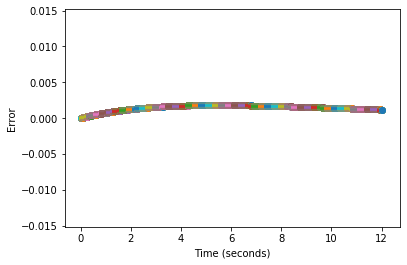

In [84]:
g = 9.81
c = 12.5
m = 68.0

delt = 0.001
tt = 0
vv_numerical = 0
v_analytical = 0
err=0
relative_err = -100
import math
import matplotlib.pyplot as plt           
while tt <= 12:
    print(tt,vv_numerical,v_analytical,err,relative_err)
    p22 = plt.scatter(tt,err)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Error')
    vv_numerical = diff(vv_numerical,tt,g,c,m,delt)
    tt += delt
    a=math.exp(-c*tt/m)
    v_analytical = (g*m/c)*(1-a)
    err=vv_numerical-v_analytical
    relative_err=err/v_analytical

Text(0, 0.5, 'Error')

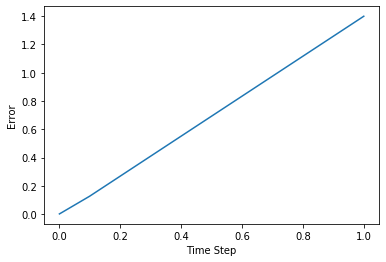

In [87]:
dt = [1.0, 0.1, 0.01, 0.001]
err = [1.3991320076550657,0.126189669039654,0.012498623506026263,0.0012490682305212886]

plt.plot(dt,err)
plt.xlabel('Time Step')
plt.ylabel('Error')